In [1]:
# =============================================================================
# A02: The Frequency Domain
# =============================================================================
# This notebook introduces the Fourier transform and frequency domain analysis.
#
# Learning Objectives:
# 1. Explain the intuition behind the Fourier transform
# 2. Distinguish between amplitude spectrum and phase spectrum
# 3. Compute the Discrete Fourier Transform (DFT) using FFT
# 4. Interpret frequency domain representations of signals
# 5. Understand frequency resolution and its relationship to signal duration
# =============================================================================

import sys
sys.path.insert(0, "../../..")

import numpy as np
from numpy.typing import NDArray
from typing import Optional, Tuple
import matplotlib.pyplot as plt
from scipy import fft

from src.colors import COLORS
from src.plotting import configure_plots
from src.signals import (
    generate_time_vector,
    generate_sine_wave,
    generate_composite_signal,
    generate_pink_noise,
)

configure_plots()

# A02: The Frequency Domain

**Duration**: ~60 minutes  
**Prerequisites**: A01 (Signals and Sampling)

---
## 1. Introduction

In the previous notebook, we explored how signals vary over time — the **time domain** representation. While this view is intuitive and shows us the raw amplitude fluctuations, it often hides the underlying structure of complex signals like EEG.

EEG signals are fundamentally **oscillatory**. Different brain states are characterized by rhythmic activity at specific frequencies: alpha waves (8-12 Hz) dominate when we close our eyes and relax, beta waves (13-30 Hz) emerge during focused attention, and theta waves (4-8 Hz) appear during drowsiness or meditation. Looking at raw EEG in the time domain, these rhythms are mixed together, making them difficult to identify and quantify.

The **frequency domain** provides a powerful alternative view. Instead of asking "what is the amplitude at each moment in time?", we ask "how much of each frequency is present in the signal?". This transformation reveals the hidden oscillatory components that are superimposed in the time domain.

The mathematical tool that bridges these two domains is the **Fourier transform**. Named after Joseph Fourier, who discovered that any signal can be represented as a sum of sine waves, this transform is the foundation of modern signal processing. In the context of hyperscanning and connectivity analysis, the frequency domain is essential — most connectivity metrics (coherence, PLV, PLI, etc.) operate on frequency-specific representations of the data.

---
## 2. Intuition — Signals as Sums of Oscillations

One of the most profound insights in mathematics is **Fourier's theorem**: any signal can be represented as a sum of sine waves of different frequencies, amplitudes, and phases. This is not just an approximation — it's an exact decomposition.

Think of it like a musical chord. When you play a C major chord on a piano, you're simultaneously pressing three keys (C, E, G). Your ear hears a single "sound," but it's actually three distinct frequencies combined. The Fourier transform is like having perfect pitch — it tells you exactly which notes (frequencies) are being played and how loud each one is.

Each sine wave component has three properties:
- **Frequency**: How fast it oscillates (in Hz)
- **Amplitude**: How strong it is (the height of the wave)
- **Phase**: Where in its cycle it starts (the timing offset)

The Fourier transform answers: *"Which frequencies are present, with what amplitudes and phases?"*

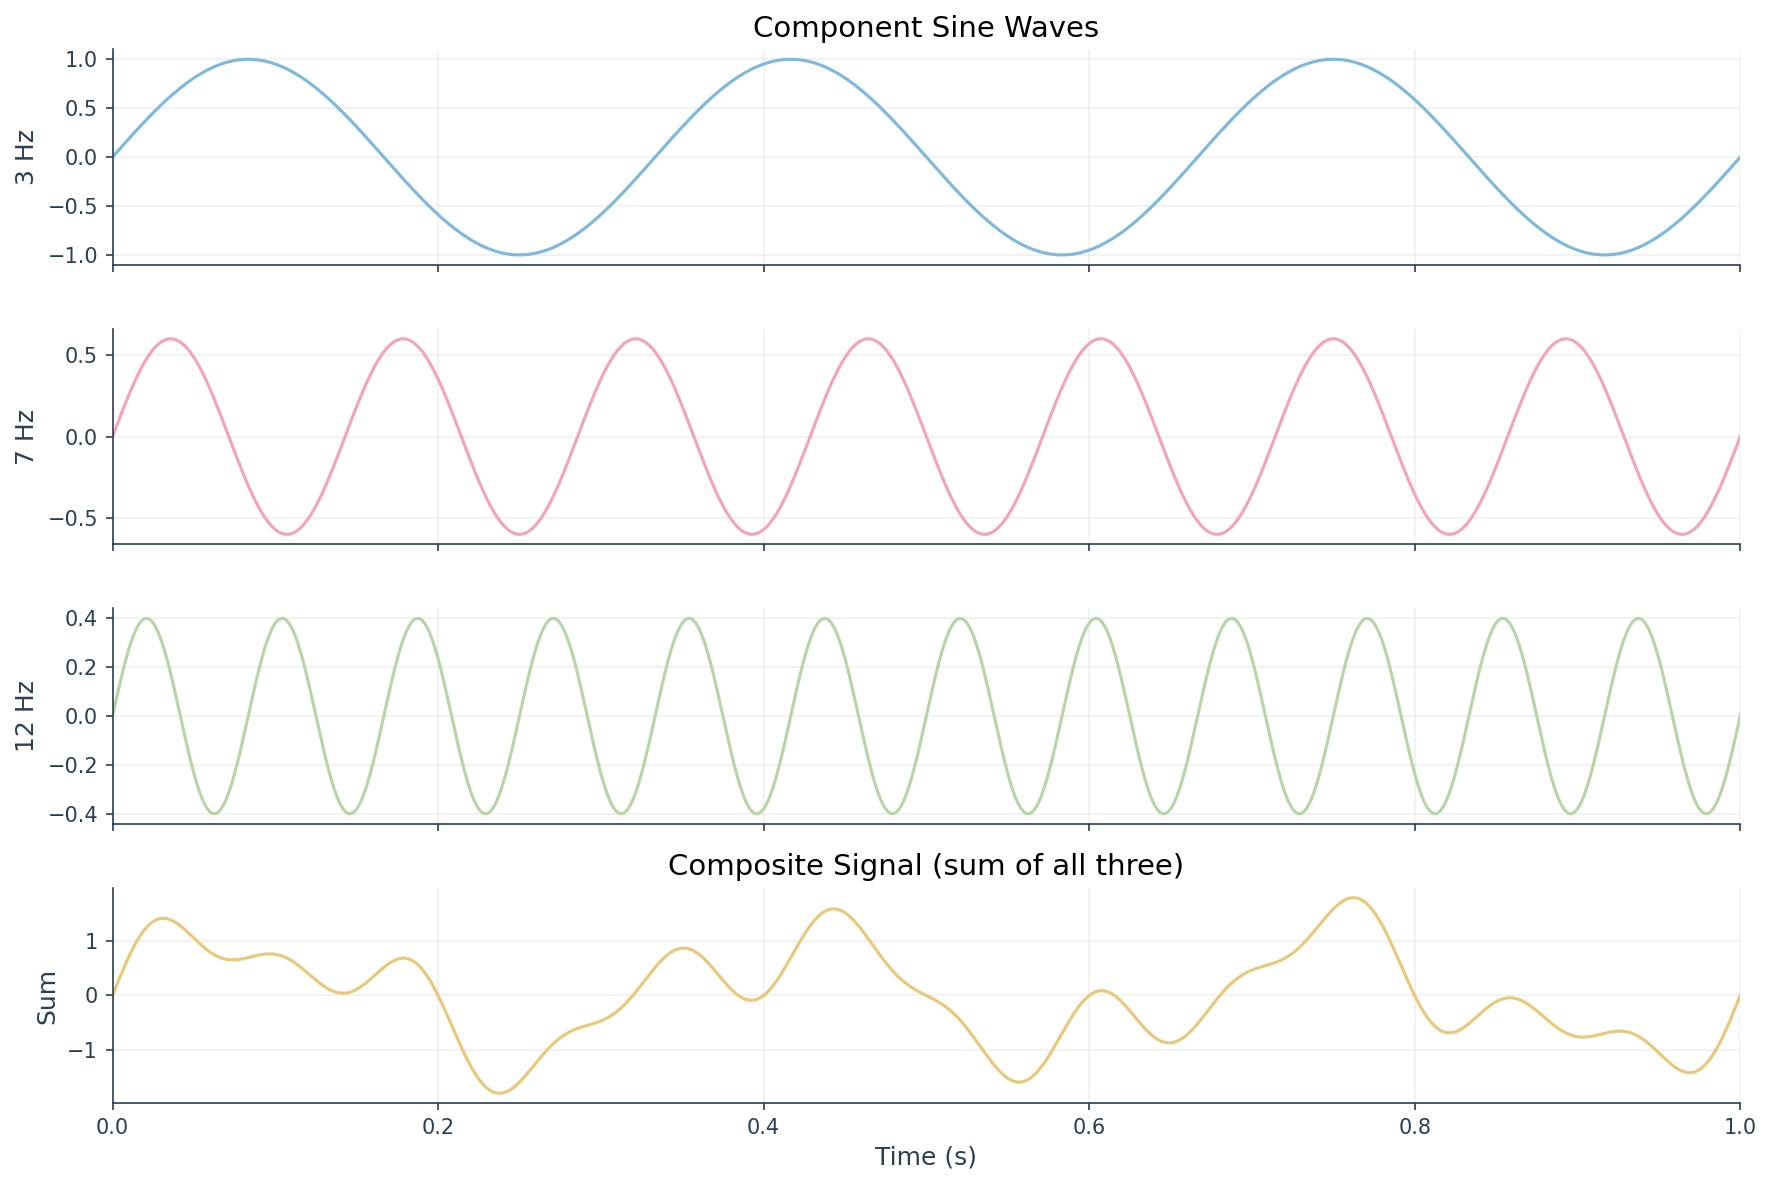

The composite signal contains: 3 Hz + 7 Hz + 12 Hz
The Fourier transform will reveal these hidden components!


In [2]:
# Visualization 1: Building a composite signal from sine waves
# Let's see how three simple oscillations combine into a complex signal

duration = 2.0  # seconds
fs = 500  # Hz
t = generate_time_vector(duration=duration, fs=fs)

# Three component frequencies (like three notes in a chord)
freq_1, amp_1 = 3, 1.0   # Low frequency, strong
freq_2, amp_2 = 7, 0.6   # Medium frequency
freq_3, amp_3 = 12, 0.4  # Higher frequency, weaker

# Generate individual components
signal_1 = generate_sine_wave(t, frequency=freq_1, amplitude=amp_1)
signal_2 = generate_sine_wave(t, frequency=freq_2, amplitude=amp_2)
signal_3 = generate_sine_wave(t, frequency=freq_3, amplitude=amp_3)

# Combine them
composite = signal_1 + signal_2 + signal_3

# Plot
fig, axes = plt.subplots(4, 1, figsize=(12, 8), sharex=True)

axes[0].plot(t, signal_1, color=COLORS["signal_1"], linewidth=1.5)
axes[0].set_ylabel(f"{freq_1} Hz")
axes[0].set_title("Component Sine Waves")

axes[1].plot(t, signal_2, color=COLORS["signal_2"], linewidth=1.5)
axes[1].set_ylabel(f"{freq_2} Hz")

axes[2].plot(t, signal_3, color=COLORS["signal_3"], linewidth=1.5)
axes[2].set_ylabel(f"{freq_3} Hz")

axes[3].plot(t, composite, color=COLORS["signal_4"], linewidth=1.5)
axes[3].set_ylabel("Sum")
axes[3].set_xlabel("Time (s)")
axes[3].set_title("Composite Signal (sum of all three)")

for ax in axes:
    ax.set_xlim(0, 1)  # Show first second only for clarity
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"The composite signal contains: {freq_1} Hz + {freq_2} Hz + {freq_3} Hz")
print("The Fourier transform will reveal these hidden components!")

### The Reverse Problem: Decomposition

Looking at the composite signal above, can you identify the three component frequencies? It's nearly impossible by eye! The signal looks like a complex, irregular waveform.

This is exactly what the Fourier transform solves: given a complex signal, it automatically decomposes it into its constituent frequencies.

---
## 3. The Fourier Transform

The **Fourier Transform** converts a time-domain signal $x(t)$ into a frequency-domain representation $X(f)$.

### Continuous Fourier Transform (conceptual)

$$X(f) = \int_{-\infty}^{\infty} x(t) \, e^{-2\pi i f t} \, dt$$

Where:
- $x(t)$ is the input signal (function of time)
- $X(f)$ is the output (function of frequency)
- $e^{-2\pi i f t}$ is a complex exponential (rotating phasor)
- $i$ is the imaginary unit ($\sqrt{-1}$)

### Discrete Fourier Transform (DFT)

For digital signals with $N$ samples, we use the **Discrete Fourier Transform**:

$$X[k] = \sum_{n=0}^{N-1} x[n] \, e^{-2\pi i k n / N}$$

Where:
- $x[n]$ is the $n$-th sample of the signal
- $X[k]$ is the $k$-th frequency bin
- $k$ ranges from $0$ to $N-1$

### Key insight

The output $X[k]$ is a **complex number** for each frequency. This complex number encodes:
- **Amplitude**: $|X[k]| = \sqrt{a^2 + b^2}$ — how much of that frequency is present
- **Phase**: $\phi = \text{atan2}(b, a)$ — the timing offset of that frequency component

### The FFT Algorithm

The **Fast Fourier Transform (FFT)** is an efficient algorithm to compute the DFT. Instead of $O(N^2)$ operations, it requires only $O(N \log N)$, making it practical for large signals.

---
## 4. Computing the FFT in Python

Let's implement the FFT using `scipy.fft`. The key steps are:
1. Apply FFT to get complex-valued output
2. Construct the frequency axis to know which index corresponds to which frequency

In [3]:
def compute_fft(
    signal: NDArray[np.float64],
    fs: float
) -> Tuple[NDArray[np.float64], NDArray[np.complex128]]:
    """
    Compute the Fast Fourier Transform of a signal.
    
    Parameters
    ----------
    signal : NDArray[np.float64]
        Input signal in time domain.
    fs : float
        Sampling frequency in Hz.
        
    Returns
    -------
    frequencies : NDArray[np.float64]
        Array of frequencies corresponding to FFT bins.
    fft_values : NDArray[np.complex128]
        Complex FFT values.
    """
    n_samples = len(signal)
    fft_values = fft.fft(signal)
    frequencies = fft.fftfreq(n_samples, d=1/fs)
    return frequencies, fft_values

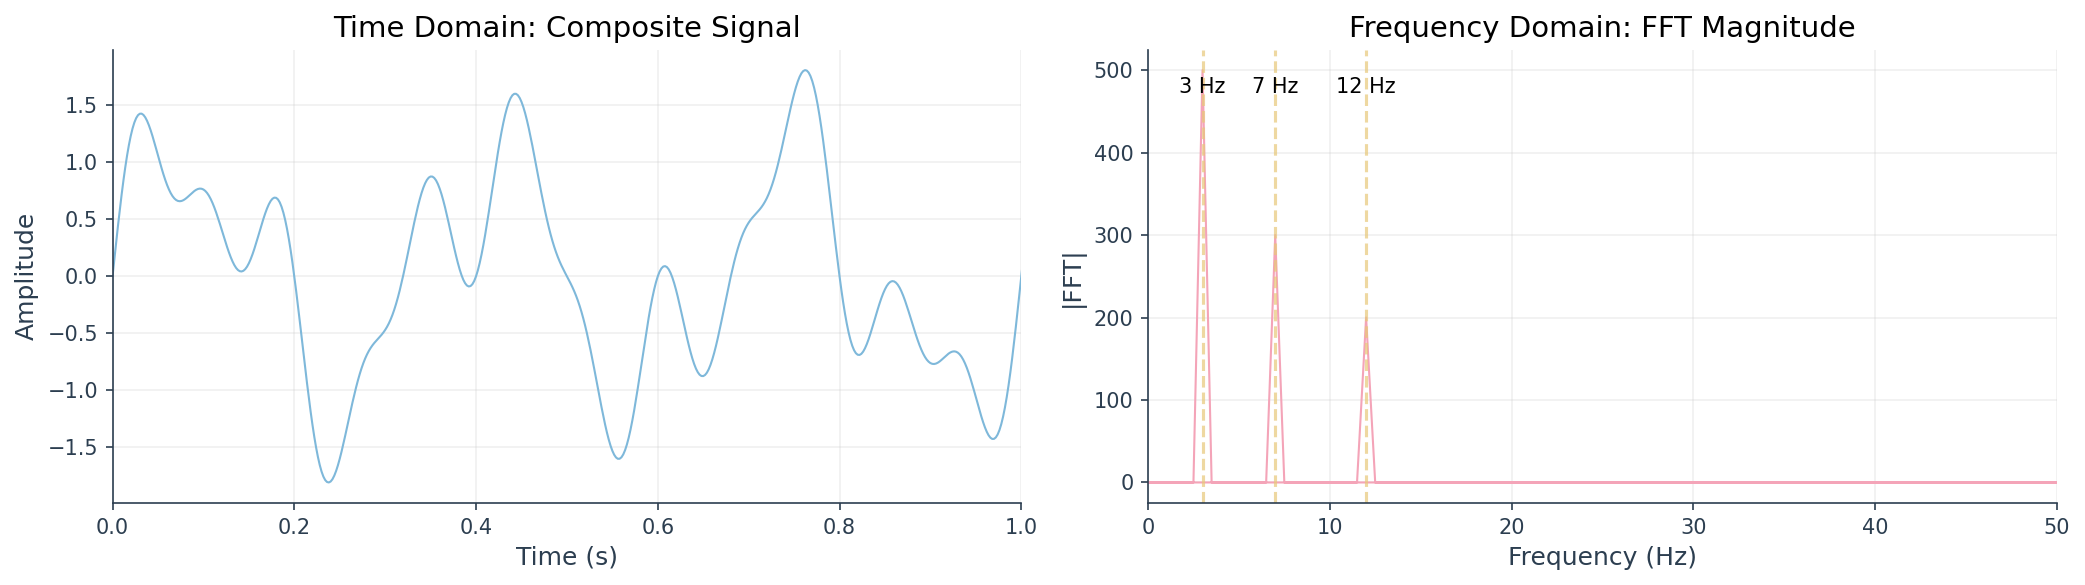

The FFT reveals the three component frequencies as clear peaks!
Peaks at: 3 Hz, 7 Hz, 12 Hz


In [4]:
# Visualization 3 & 4: FFT in action
# Let's apply our function to the composite signal from earlier

duration = 2.0
fs = 500
t = generate_time_vector(duration=duration, fs=fs)

# Recreate our composite signal
freq_1, amp_1 = 3, 1.0
freq_2, amp_2 = 7, 0.6
freq_3, amp_3 = 12, 0.4

signal_1 = generate_sine_wave(t, frequency=freq_1, amplitude=amp_1)
signal_2 = generate_sine_wave(t, frequency=freq_2, amplitude=amp_2)
signal_3 = generate_sine_wave(t, frequency=freq_3, amplitude=amp_3)
composite = signal_1 + signal_2 + signal_3

# Compute FFT
frequencies, fft_values = compute_fft(composite, fs)

# Plot both time and frequency domain
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Time domain
axes[0].plot(t, composite, color=COLORS["signal_1"], linewidth=1)
axes[0].set_xlabel("Time (s)")
axes[0].set_ylabel("Amplitude")
axes[0].set_title("Time Domain: Composite Signal")
axes[0].set_xlim(0, 1)
axes[0].grid(True, alpha=0.3)

# Frequency domain (magnitude of FFT)
axes[1].plot(frequencies, np.abs(fft_values), color=COLORS["signal_2"], linewidth=1)
axes[1].set_xlabel("Frequency (Hz)")
axes[1].set_ylabel("|FFT|")
axes[1].set_title("Frequency Domain: FFT Magnitude")
axes[1].set_xlim(0, 50)  # Show up to 50 Hz
axes[1].grid(True, alpha=0.3)

# Mark the component frequencies
for freq in [freq_1, freq_2, freq_3]:
    axes[1].axvline(freq, color=COLORS["signal_4"], linestyle="--", alpha=0.7)
    axes[1].annotate(f"{freq} Hz", (freq, axes[1].get_ylim()[1]*0.9), 
                     ha="center", fontsize=10)

plt.tight_layout()
plt.show()

print("The FFT reveals the three component frequencies as clear peaks!")
print(f"Peaks at: {freq_1} Hz, {freq_2} Hz, {freq_3} Hz")

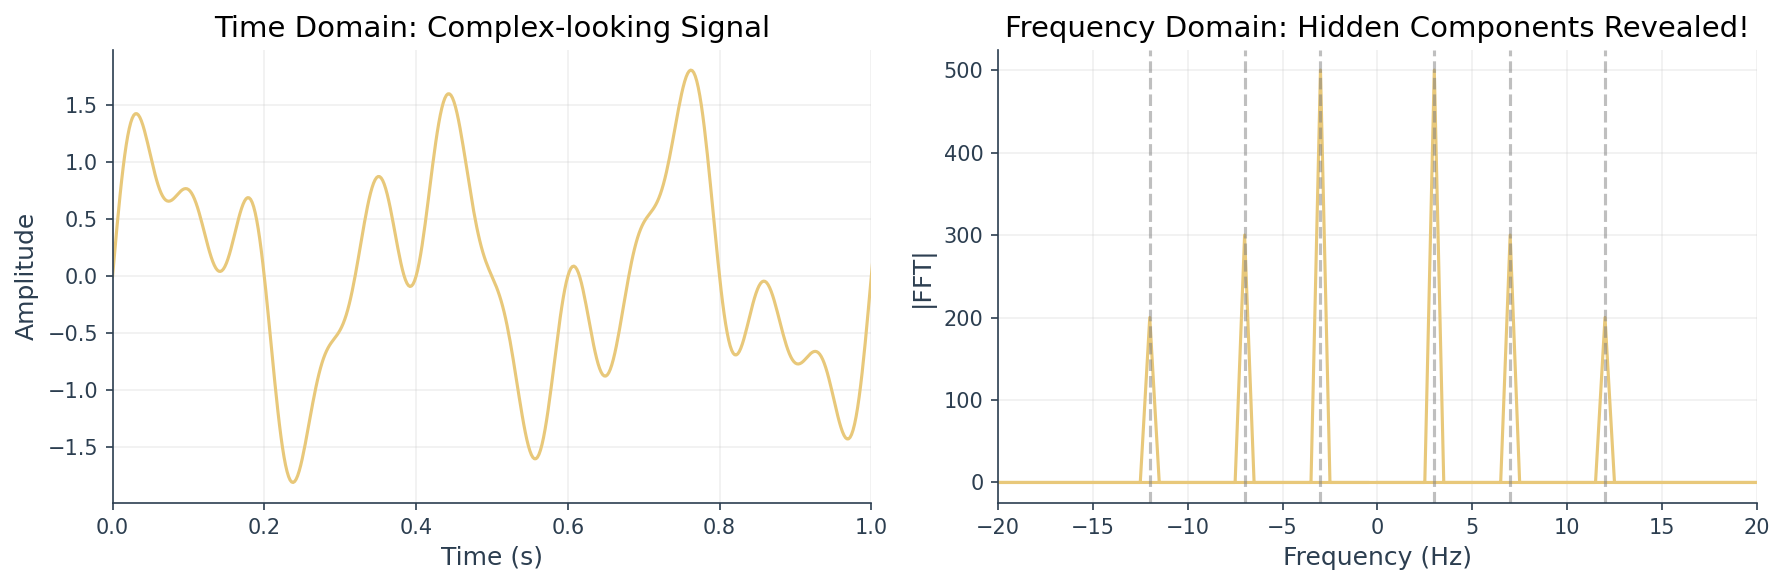

The FFT clearly reveals the three components: 3 Hz, 7 Hz, 12 Hz
This is the power of frequency domain analysis!


In [5]:
# Visualization 4: FFT reveals hidden components in composite signal
# Let's apply FFT to our composite signal from Section 2

freqs_composite, fft_composite = compute_fft(composite, fs)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Time domain - looks complex
axes[0].plot(t, composite, color=COLORS["signal_4"], linewidth=1.5)
axes[0].set_xlabel("Time (s)")
axes[0].set_ylabel("Amplitude")
axes[0].set_title("Time Domain: Complex-looking Signal")
axes[0].set_xlim(0, 1)
axes[0].grid(True, alpha=0.3)

# Frequency domain - clear peaks!
axes[1].plot(freqs_composite, np.abs(fft_composite), color=COLORS["signal_4"], linewidth=1.5)
axes[1].set_xlabel("Frequency (Hz)")
axes[1].set_ylabel("|FFT|")
axes[1].set_title("Frequency Domain: Hidden Components Revealed!")
axes[1].set_xlim(-20, 20)
axes[1].grid(True, alpha=0.3)

# Annotate the peaks
for freq in [freq_1, freq_2, freq_3]:
    axes[1].axvline(freq, color="gray", linestyle="--", alpha=0.5)
    axes[1].axvline(-freq, color="gray", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

print(f"The FFT clearly reveals the three components: {freq_1} Hz, {freq_2} Hz, {freq_3} Hz")
print("This is the power of frequency domain analysis!")

---
## 5. Amplitude Spectrum

The FFT output is complex: $X[k] = a + bi$. The **amplitude** (or magnitude) tells us *how much* of each frequency is present:

$$|X[k]| = \sqrt{a^2 + b^2}$$

For practical analysis, we typically:
1. Take only **positive frequencies** (one-sided spectrum)
2. **Normalize** by dividing by $N$ (or $N/2$ for one-sided)

This gives us the **amplitude spectrum** — the strength of each frequency component.

In [6]:
def compute_amplitude_spectrum(
    signal: NDArray[np.float64],
    fs: float,
    normalize: bool = True
) -> Tuple[NDArray[np.float64], NDArray[np.float64]]:
    """
    Compute the one-sided amplitude spectrum of a signal.
    
    Parameters
    ----------
    signal : NDArray[np.float64]
        Input signal in time domain.
    fs : float
        Sampling frequency in Hz.
    normalize : bool, optional
        If True, normalize amplitudes. Default is True.
        
    Returns
    -------
    frequencies : NDArray[np.float64]
        Array of positive frequencies.
    amplitudes : NDArray[np.float64]
        Amplitude at each frequency.
    """
    n_samples = len(signal)
    fft_values = fft.fft(signal)
    
    # One-sided spectrum (positive frequencies only)
    n_positive = n_samples // 2
    frequencies = fft.fftfreq(n_samples, d=1/fs)[:n_positive]
    amplitudes = np.abs(fft_values[:n_positive])
    
    if normalize:
        amplitudes = amplitudes * 2 / n_samples  # Factor 2 for one-sided
        amplitudes[0] /= 2  # DC component should not be doubled
    
    return frequencies, amplitudes

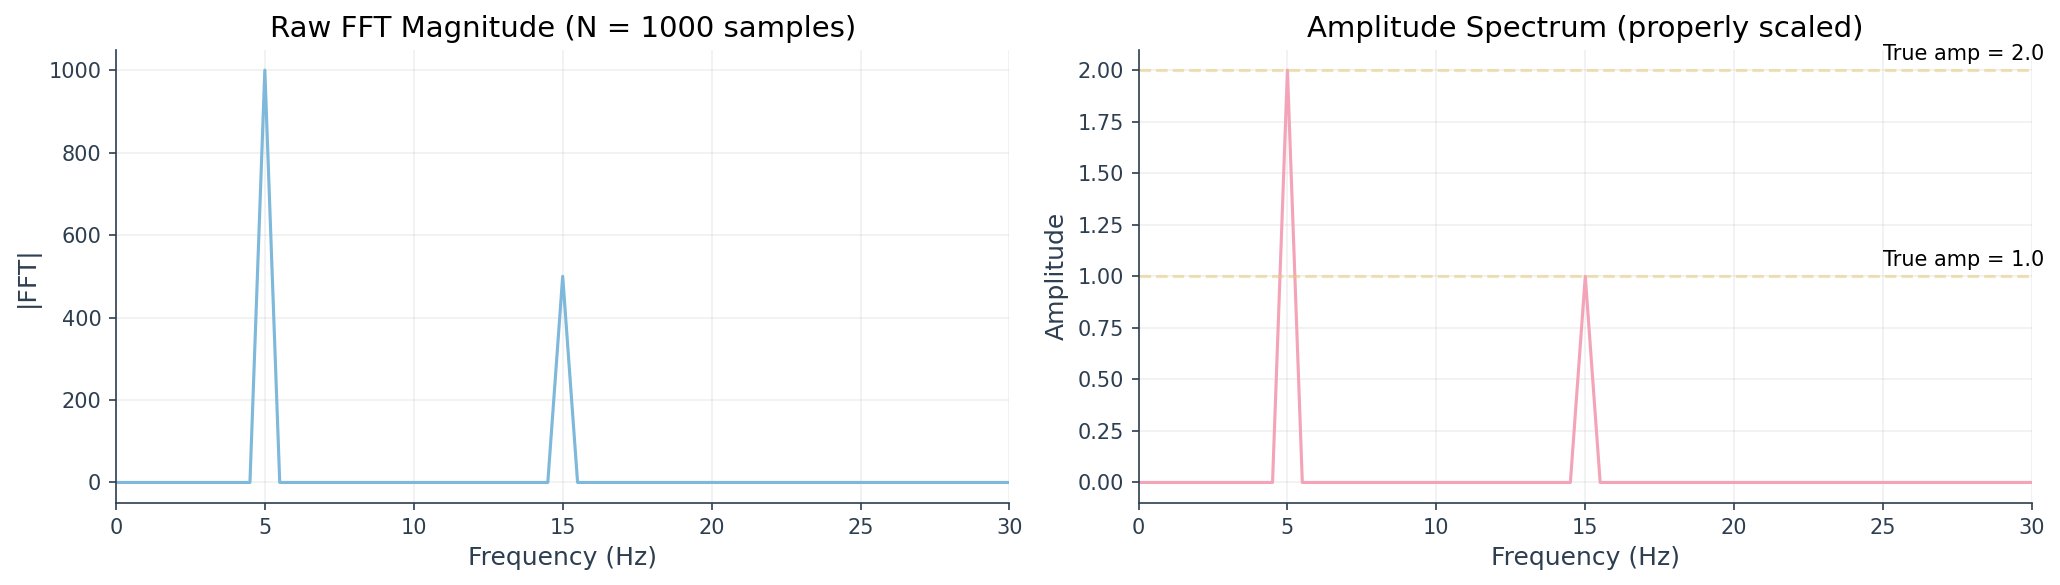

Original amplitudes: 2.0 at 5 Hz, 1.0 at 15 Hz
Recovered amplitudes (from peaks): ~2.00 and ~1.00


In [7]:
# Visualization 5: Amplitude spectrum with proper scaling
# Compare raw FFT magnitude vs properly scaled amplitude spectrum

duration = 2.0
fs = 500
t = generate_time_vector(duration=duration, fs=fs)
n_samples = len(t)

# Create signal with known amplitudes
freq_1, amp_1 = 5, 2.0   # 5 Hz with amplitude 2
freq_2, amp_2 = 15, 1.0  # 15 Hz with amplitude 1

signal = (generate_sine_wave(t, frequency=freq_1, amplitude=amp_1) + 
          generate_sine_wave(t, frequency=freq_2, amplitude=amp_2))

# Compute both representations
frequencies_full, fft_values = compute_fft(signal, fs)
frequencies_pos, amplitude_spectrum = compute_amplitude_spectrum(signal, fs)

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Raw FFT magnitude (only positive frequencies for comparison)
positive_mask = frequencies_full >= 0
axes[0].plot(frequencies_full[positive_mask], np.abs(fft_values[positive_mask]), 
             color=COLORS["signal_1"], linewidth=1.5)
axes[0].set_xlabel("Frequency (Hz)")
axes[0].set_ylabel("|FFT|")
axes[0].set_title(f"Raw FFT Magnitude (N = {n_samples} samples)")
axes[0].set_xlim(0, 30)
axes[0].grid(True, alpha=0.3)

# Properly scaled amplitude spectrum
axes[1].plot(frequencies_pos, amplitude_spectrum, color=COLORS["signal_2"], linewidth=1.5)
axes[1].set_xlabel("Frequency (Hz)")
axes[1].set_ylabel("Amplitude")
axes[1].set_title("Amplitude Spectrum (properly scaled)")
axes[1].set_xlim(0, 30)
axes[1].grid(True, alpha=0.3)

# Add horizontal lines at true amplitudes
for amp, freq in [(amp_1, freq_1), (amp_2, freq_2)]:
    axes[1].axhline(amp, color=COLORS["signal_4"], linestyle="--", alpha=0.5)
    axes[1].annotate(f"True amp = {amp}", (25, amp + 0.05), fontsize=10)

plt.tight_layout()
plt.show()

print(f"Original amplitudes: {amp_1} at {freq_1} Hz, {amp_2} at {freq_2} Hz")
print(f"Recovered amplitudes (from peaks): ~{amplitude_spectrum[np.argmin(np.abs(frequencies_pos - freq_1))]:.2f} and ~{amplitude_spectrum[np.argmin(np.abs(frequencies_pos - freq_2))]:.2f}")

---
## 6. Phase Spectrum

While amplitude tells us *how much* of each frequency is present, **phase** tells us *when* each oscillation starts. The phase is the angle of the complex FFT output:

$$\phi[k] = \text{atan2}(\text{Im}(X[k]), \text{Re}(X[k]))$$

Phase is measured in **radians** (from $-\pi$ to $\pi$) or degrees (from -180° to 180°).

### Why phase matters

Phase is often ignored in simple spectral analysis, but it's **crucial for connectivity**:
- **Phase-Locking Value (PLV)** measures consistency of phase differences
- **Phase-Lag Index (PLI)** detects directional phase relationships
- **Coherence** combines both amplitude and phase information

Two signals can have identical amplitude spectra but look completely different in time domain — because they have different phases!

In [8]:
def compute_phase_spectrum(
    signal: NDArray[np.float64],
    fs: float
) -> Tuple[NDArray[np.float64], NDArray[np.float64]]:
    """
    Compute the one-sided phase spectrum of a signal.
    
    Parameters
    ----------
    signal : NDArray[np.float64]
        Input signal in time domain.
    fs : float
        Sampling frequency in Hz.
        
    Returns
    -------
    frequencies : NDArray[np.float64]
        Array of positive frequencies.
    phases : NDArray[np.float64]
        Phase in radians at each frequency.
    """
    n_samples = len(signal)
    fft_values = fft.fft(signal)
    
    # One-sided spectrum
    n_positive = n_samples // 2
    frequencies = fft.fftfreq(n_samples, d=1/fs)[:n_positive]
    phases = np.angle(fft_values[:n_positive])
    
    return frequencies, phases

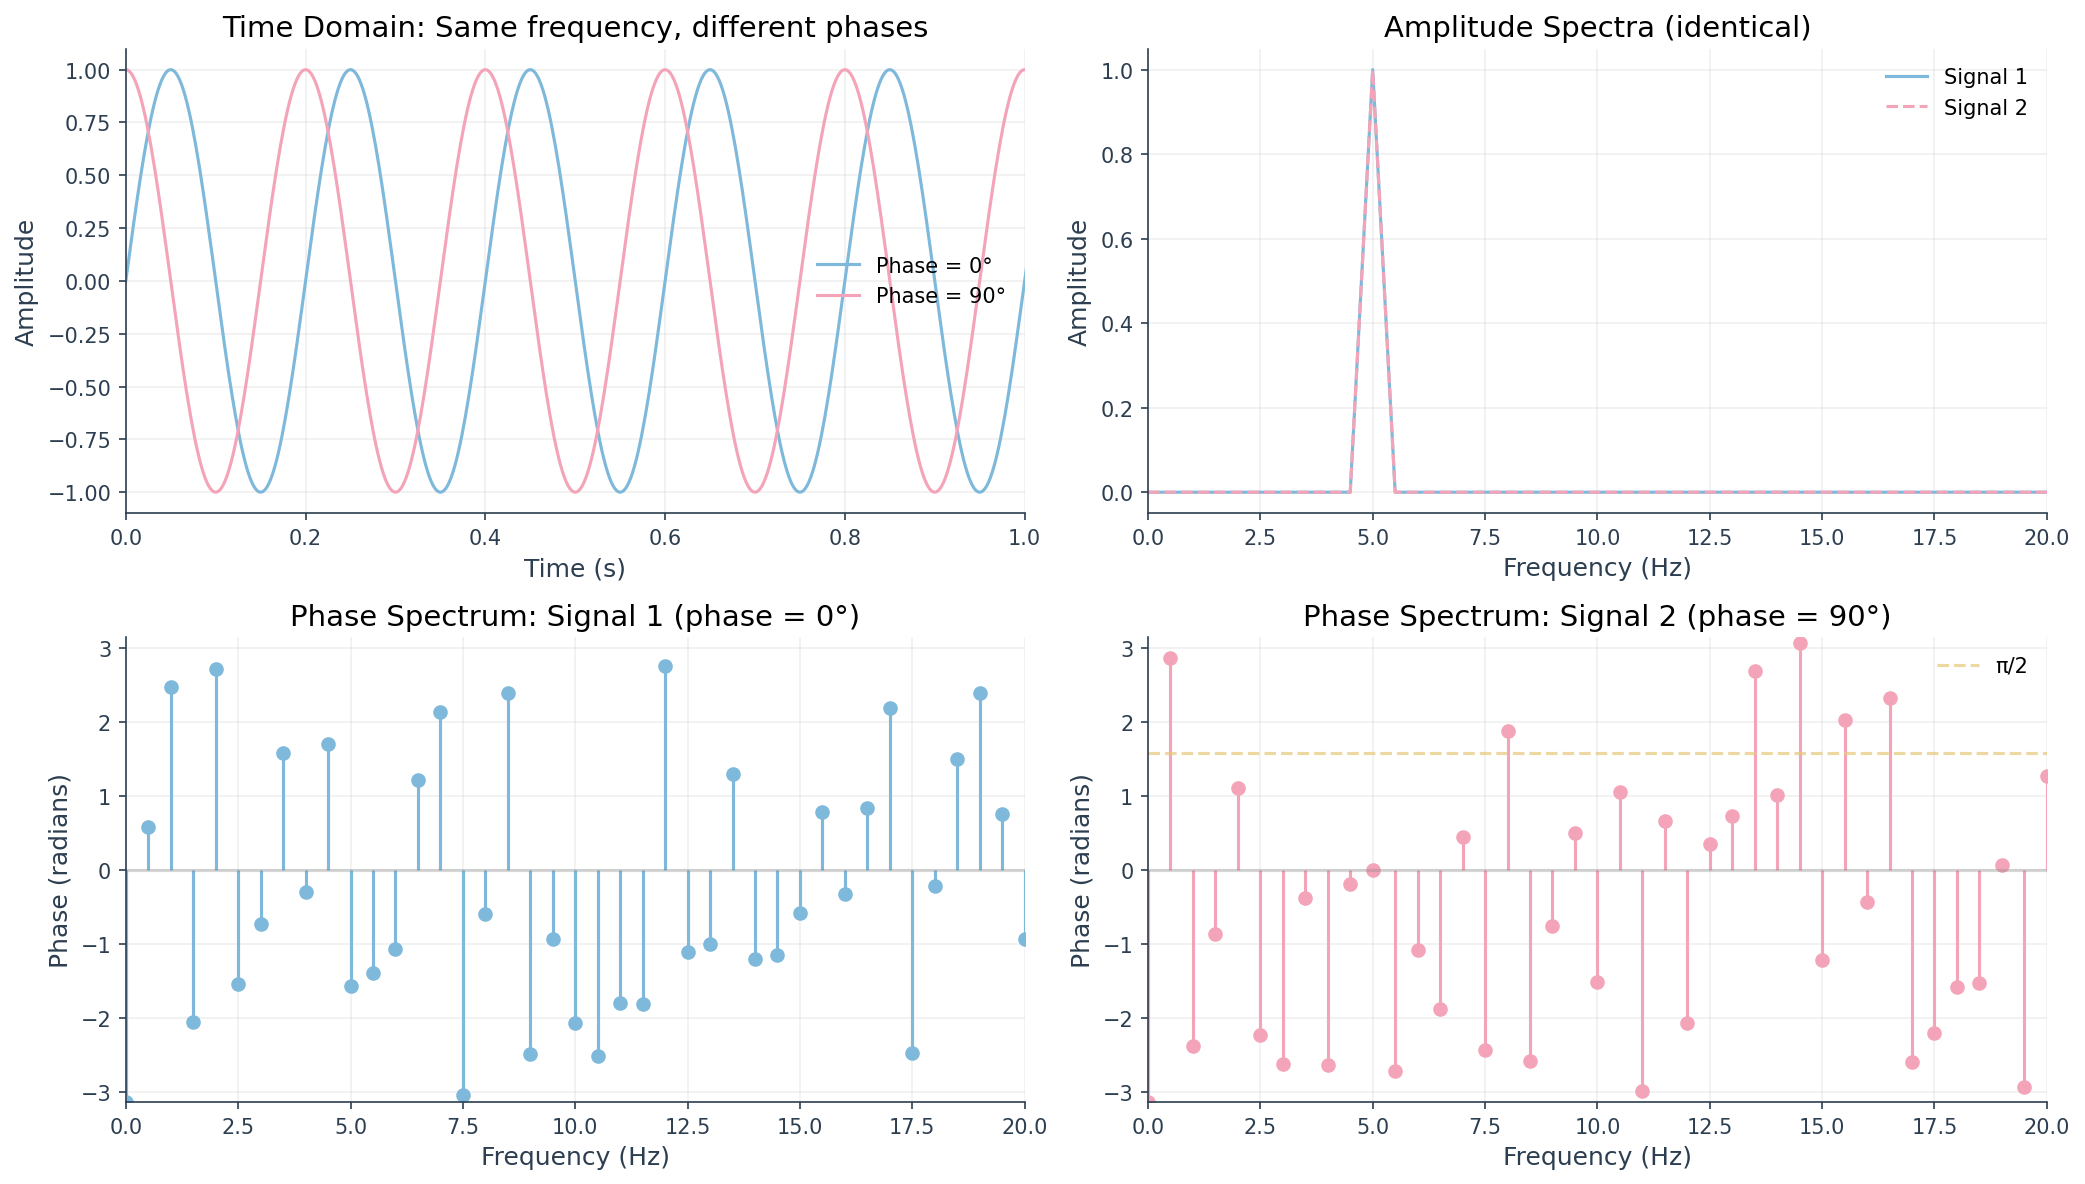

Phase at 5 Hz:
  Signal 1: -1.571 rad ≈ -90.0°
  Signal 2: 0.000 rad ≈ 0.0°


In [9]:
# Visualization 6: Phase spectrum
# The phase tells us the timing offset of each frequency component

duration = 2.0
fs = 500
t = generate_time_vector(duration=duration, fs=fs)

# Create two signals with the same frequency but different phases
freq = 5  # Hz
phase_1 = 0           # No phase shift (starts at 0)
phase_2 = np.pi / 2   # 90° phase shift (starts at maximum)

signal_1 = generate_sine_wave(t, frequency=freq, amplitude=1.0, phase=phase_1)
signal_2 = generate_sine_wave(t, frequency=freq, amplitude=1.0, phase=phase_2)

# Compute phase spectra
frequencies, phase_spectrum_1 = compute_phase_spectrum(signal_1, fs)
_, phase_spectrum_2 = compute_phase_spectrum(signal_2, fs)

# Plot
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Time domain comparison
axes[0, 0].plot(t, signal_1, color=COLORS["signal_1"], linewidth=1.5, label=f"Phase = 0°")
axes[0, 0].plot(t, signal_2, color=COLORS["signal_2"], linewidth=1.5, label=f"Phase = 90°")
axes[0, 0].set_xlabel("Time (s)")
axes[0, 0].set_ylabel("Amplitude")
axes[0, 0].set_title("Time Domain: Same frequency, different phases")
axes[0, 0].set_xlim(0, 1)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Amplitude spectra (should be identical)
_, amp_1 = compute_amplitude_spectrum(signal_1, fs)
_, amp_2 = compute_amplitude_spectrum(signal_2, fs)

axes[0, 1].plot(frequencies, amp_1, color=COLORS["signal_1"], linewidth=1.5, label="Signal 1")
axes[0, 1].plot(frequencies, amp_2, color=COLORS["signal_2"], linewidth=1.5, linestyle="--", label="Signal 2")
axes[0, 1].set_xlabel("Frequency (Hz)")
axes[0, 1].set_ylabel("Amplitude")
axes[0, 1].set_title("Amplitude Spectra (identical)")
axes[0, 1].set_xlim(0, 20)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Phase spectra (should differ at 5 Hz)
axes[1, 0].stem(frequencies, phase_spectrum_1, linefmt=COLORS["signal_1"], markerfmt="o", basefmt=" ")
axes[1, 0].set_xlabel("Frequency (Hz)")
axes[1, 0].set_ylabel("Phase (radians)")
axes[1, 0].set_title("Phase Spectrum: Signal 1 (phase = 0°)")
axes[1, 0].set_xlim(0, 20)
axes[1, 0].set_ylim(-np.pi, np.pi)
axes[1, 0].axhline(0, color="gray", linestyle="-", alpha=0.3)
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].stem(frequencies, phase_spectrum_2, linefmt=COLORS["signal_2"], markerfmt="o", basefmt=" ")
axes[1, 1].set_xlabel("Frequency (Hz)")
axes[1, 1].set_ylabel("Phase (radians)")
axes[1, 1].set_title("Phase Spectrum: Signal 2 (phase = 90°)")
axes[1, 1].set_xlim(0, 20)
axes[1, 1].set_ylim(-np.pi, np.pi)
axes[1, 1].axhline(np.pi/2, color=COLORS["signal_4"], linestyle="--", alpha=0.7, label="π/2")
axes[1, 1].axhline(0, color="gray", linestyle="-", alpha=0.3)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Phase at {freq} Hz:")
print(f"  Signal 1: {phase_spectrum_1[np.argmin(np.abs(frequencies - freq))]:.3f} rad ≈ {np.degrees(phase_spectrum_1[np.argmin(np.abs(frequencies - freq))]):.1f}°")
print(f"  Signal 2: {phase_spectrum_2[np.argmin(np.abs(frequencies - freq))]:.3f} rad ≈ {np.degrees(phase_spectrum_2[np.argmin(np.abs(frequencies - freq))]):.1f}°")

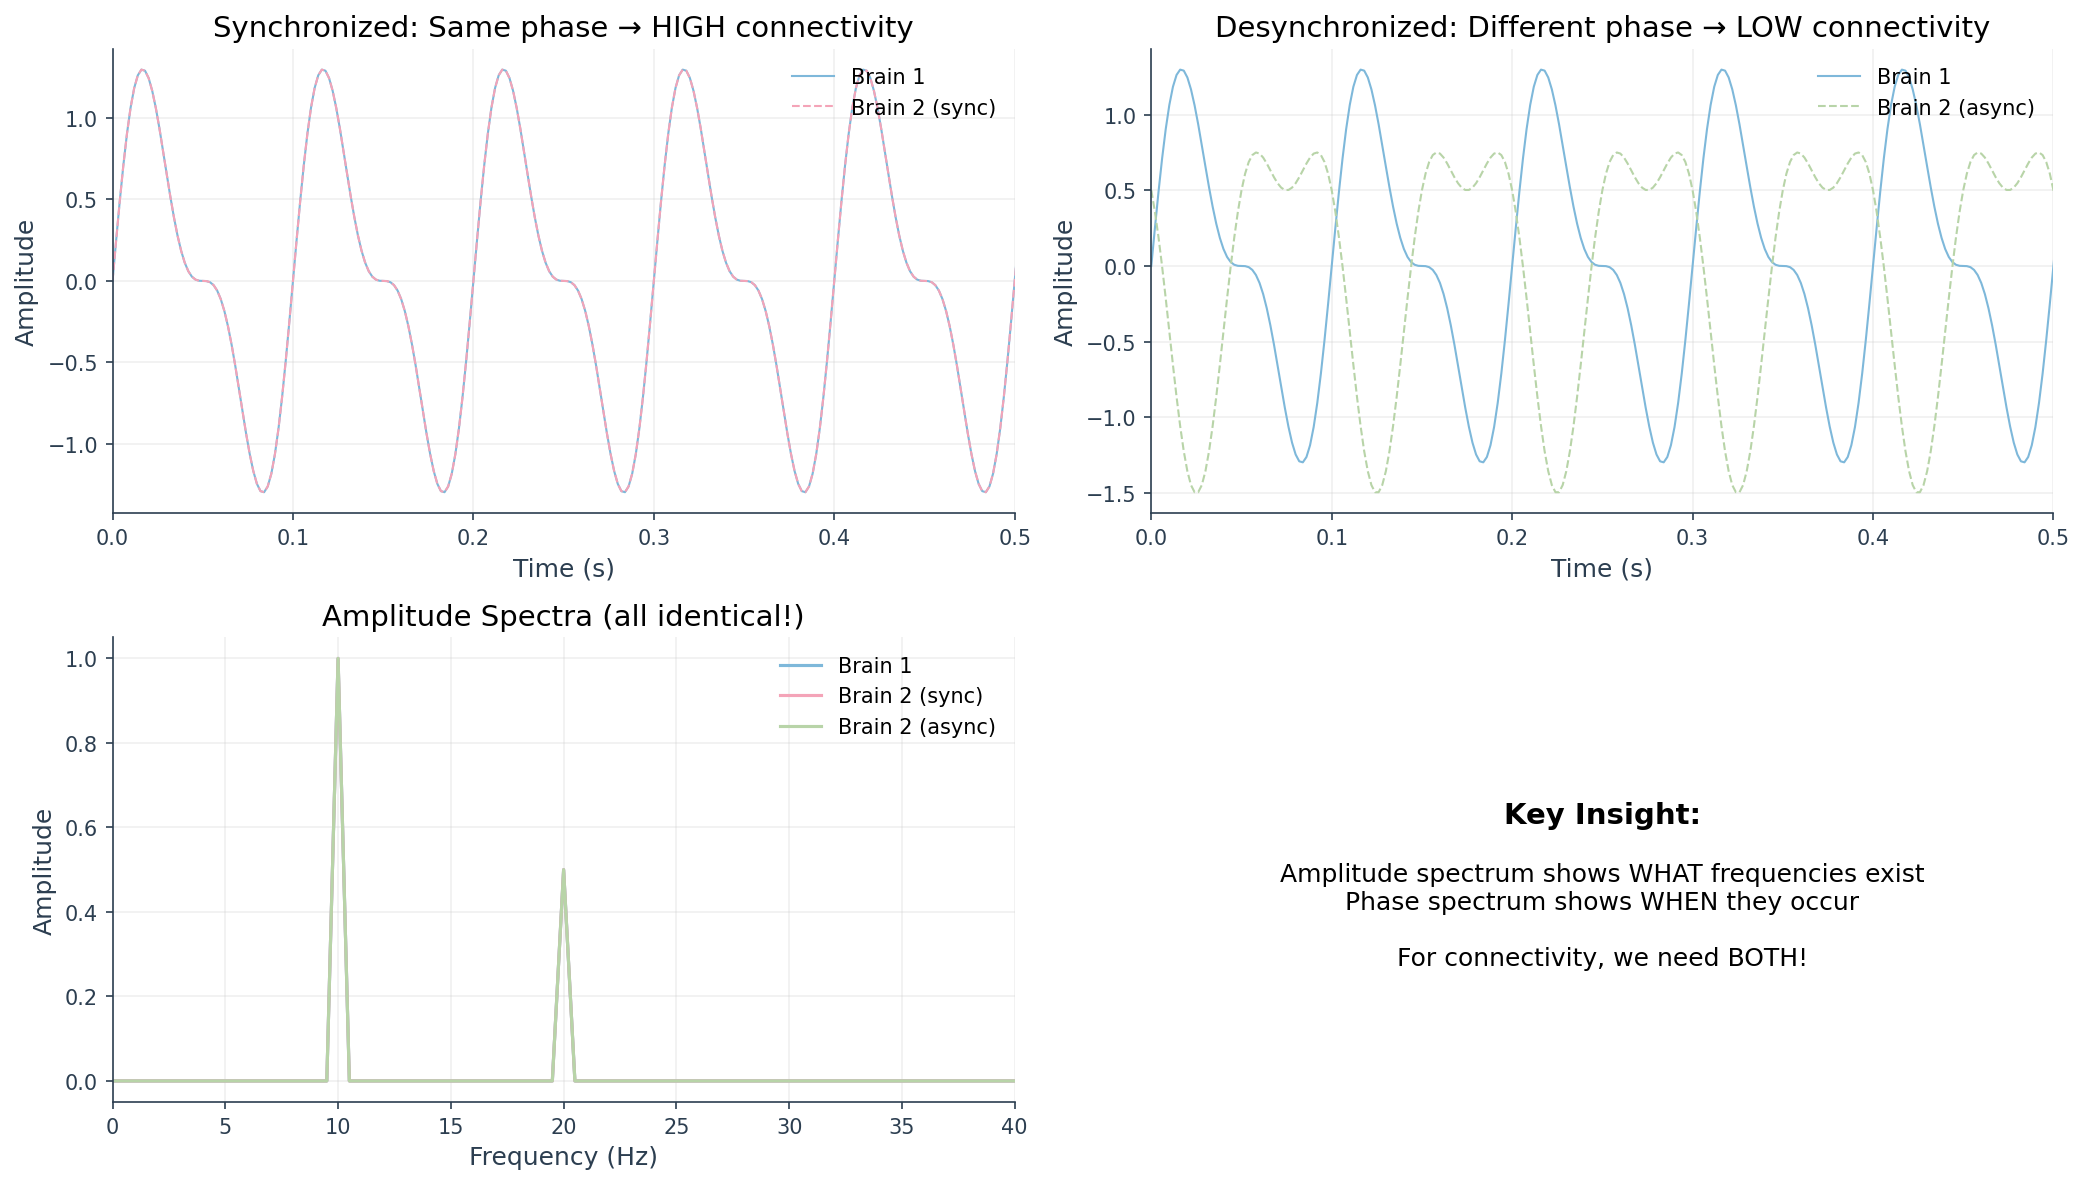

In [10]:
# Visualization 7: Why phase matters for connectivity
# Two signals with same spectrum but different phase relationships

duration = 2.0
fs = 500
t = generate_time_vector(duration=duration, fs=fs)

# Create "brain 1" signal
brain_1 = (generate_sine_wave(t, frequency=10, amplitude=1.0, phase=0) +
           generate_sine_wave(t, frequency=20, amplitude=0.5, phase=0))

# Create two versions of "brain 2" with different phase relationships
brain_2_sync = (generate_sine_wave(t, frequency=10, amplitude=1.0, phase=0) +      # In phase
                generate_sine_wave(t, frequency=20, amplitude=0.5, phase=0))

brain_2_async = (generate_sine_wave(t, frequency=10, amplitude=1.0, phase=np.pi) +  # Anti-phase
                 generate_sine_wave(t, frequency=20, amplitude=0.5, phase=np.pi/2))

# Plot
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Synchronized brains
axes[0, 0].plot(t, brain_1, color=COLORS["signal_1"], linewidth=1, label="Brain 1")
axes[0, 0].plot(t, brain_2_sync, color=COLORS["signal_2"], linewidth=1, linestyle="--", label="Brain 2 (sync)")
axes[0, 0].set_xlabel("Time (s)")
axes[0, 0].set_ylabel("Amplitude")
axes[0, 0].set_title("Synchronized: Same phase → HIGH connectivity")
axes[0, 0].set_xlim(0, 0.5)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Desynchronized brains
axes[0, 1].plot(t, brain_1, color=COLORS["signal_1"], linewidth=1, label="Brain 1")
axes[0, 1].plot(t, brain_2_async, color=COLORS["signal_3"], linewidth=1, linestyle="--", label="Brain 2 (async)")
axes[0, 1].set_xlabel("Time (s)")
axes[0, 1].set_ylabel("Amplitude")
axes[0, 1].set_title("Desynchronized: Different phase → LOW connectivity")
axes[0, 1].set_xlim(0, 0.5)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Amplitude spectra (all identical!)
for ax_idx, (signal, label, color) in enumerate([
    (brain_1, "Brain 1", COLORS["signal_1"]),
    (brain_2_sync, "Brain 2 (sync)", COLORS["signal_2"]),
    (brain_2_async, "Brain 2 (async)", COLORS["signal_3"])
]):
    frequencies, amp = compute_amplitude_spectrum(signal, fs)
    axes[1, 0].plot(frequencies, amp, color=color, linewidth=1.5, label=label)

axes[1, 0].set_xlabel("Frequency (Hz)")
axes[1, 0].set_ylabel("Amplitude")
axes[1, 0].set_title("Amplitude Spectra (all identical!)")
axes[1, 0].set_xlim(0, 40)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Text explanation
axes[1, 1].text(0.5, 0.6, "Key Insight:", fontsize=14, fontweight="bold",
                ha="center", transform=axes[1, 1].transAxes)
axes[1, 1].text(0.5, 0.4, "Amplitude spectrum shows WHAT frequencies exist\n"
                          "Phase spectrum shows WHEN they occur\n\n"
                          "For connectivity, we need BOTH!", 
                fontsize=12, ha="center", va="center", transform=axes[1, 1].transAxes)
axes[1, 1].axis("off")

plt.tight_layout()
plt.show()

---
## 7. Frequency Resolution

A critical concept in spectral analysis is **frequency resolution** — the ability to distinguish between nearby frequencies. The resolution depends on the **signal duration**:

$$\Delta f = \frac{f_s}{N} = \frac{1}{T}$$

Where:
- $\Delta f$ is the frequency resolution (spacing between FFT bins)
- $f_s$ is the sampling frequency
- $N$ is the number of samples
- $T$ is the signal duration in seconds

**Key insight**: Longer signals give better frequency resolution. A 1-second signal has 1 Hz resolution; a 0.5-second signal only has 2 Hz resolution.

This creates a fundamental **trade-off**:
- Better frequency resolution requires longer time windows
- Better temporal resolution requires shorter time windows
- You cannot have both simultaneously (uncertainty principle)

In [11]:
def compute_frequency_resolution(fs: float, n_samples: int) -> float:
    """
    Compute the frequency resolution of an FFT.
    
    Parameters
    ----------
    fs : float
        Sampling frequency in Hz.
    n_samples : int
        Number of samples in the signal.
        
    Returns
    -------
    float
        Frequency resolution in Hz.
    """
    return fs / n_samples

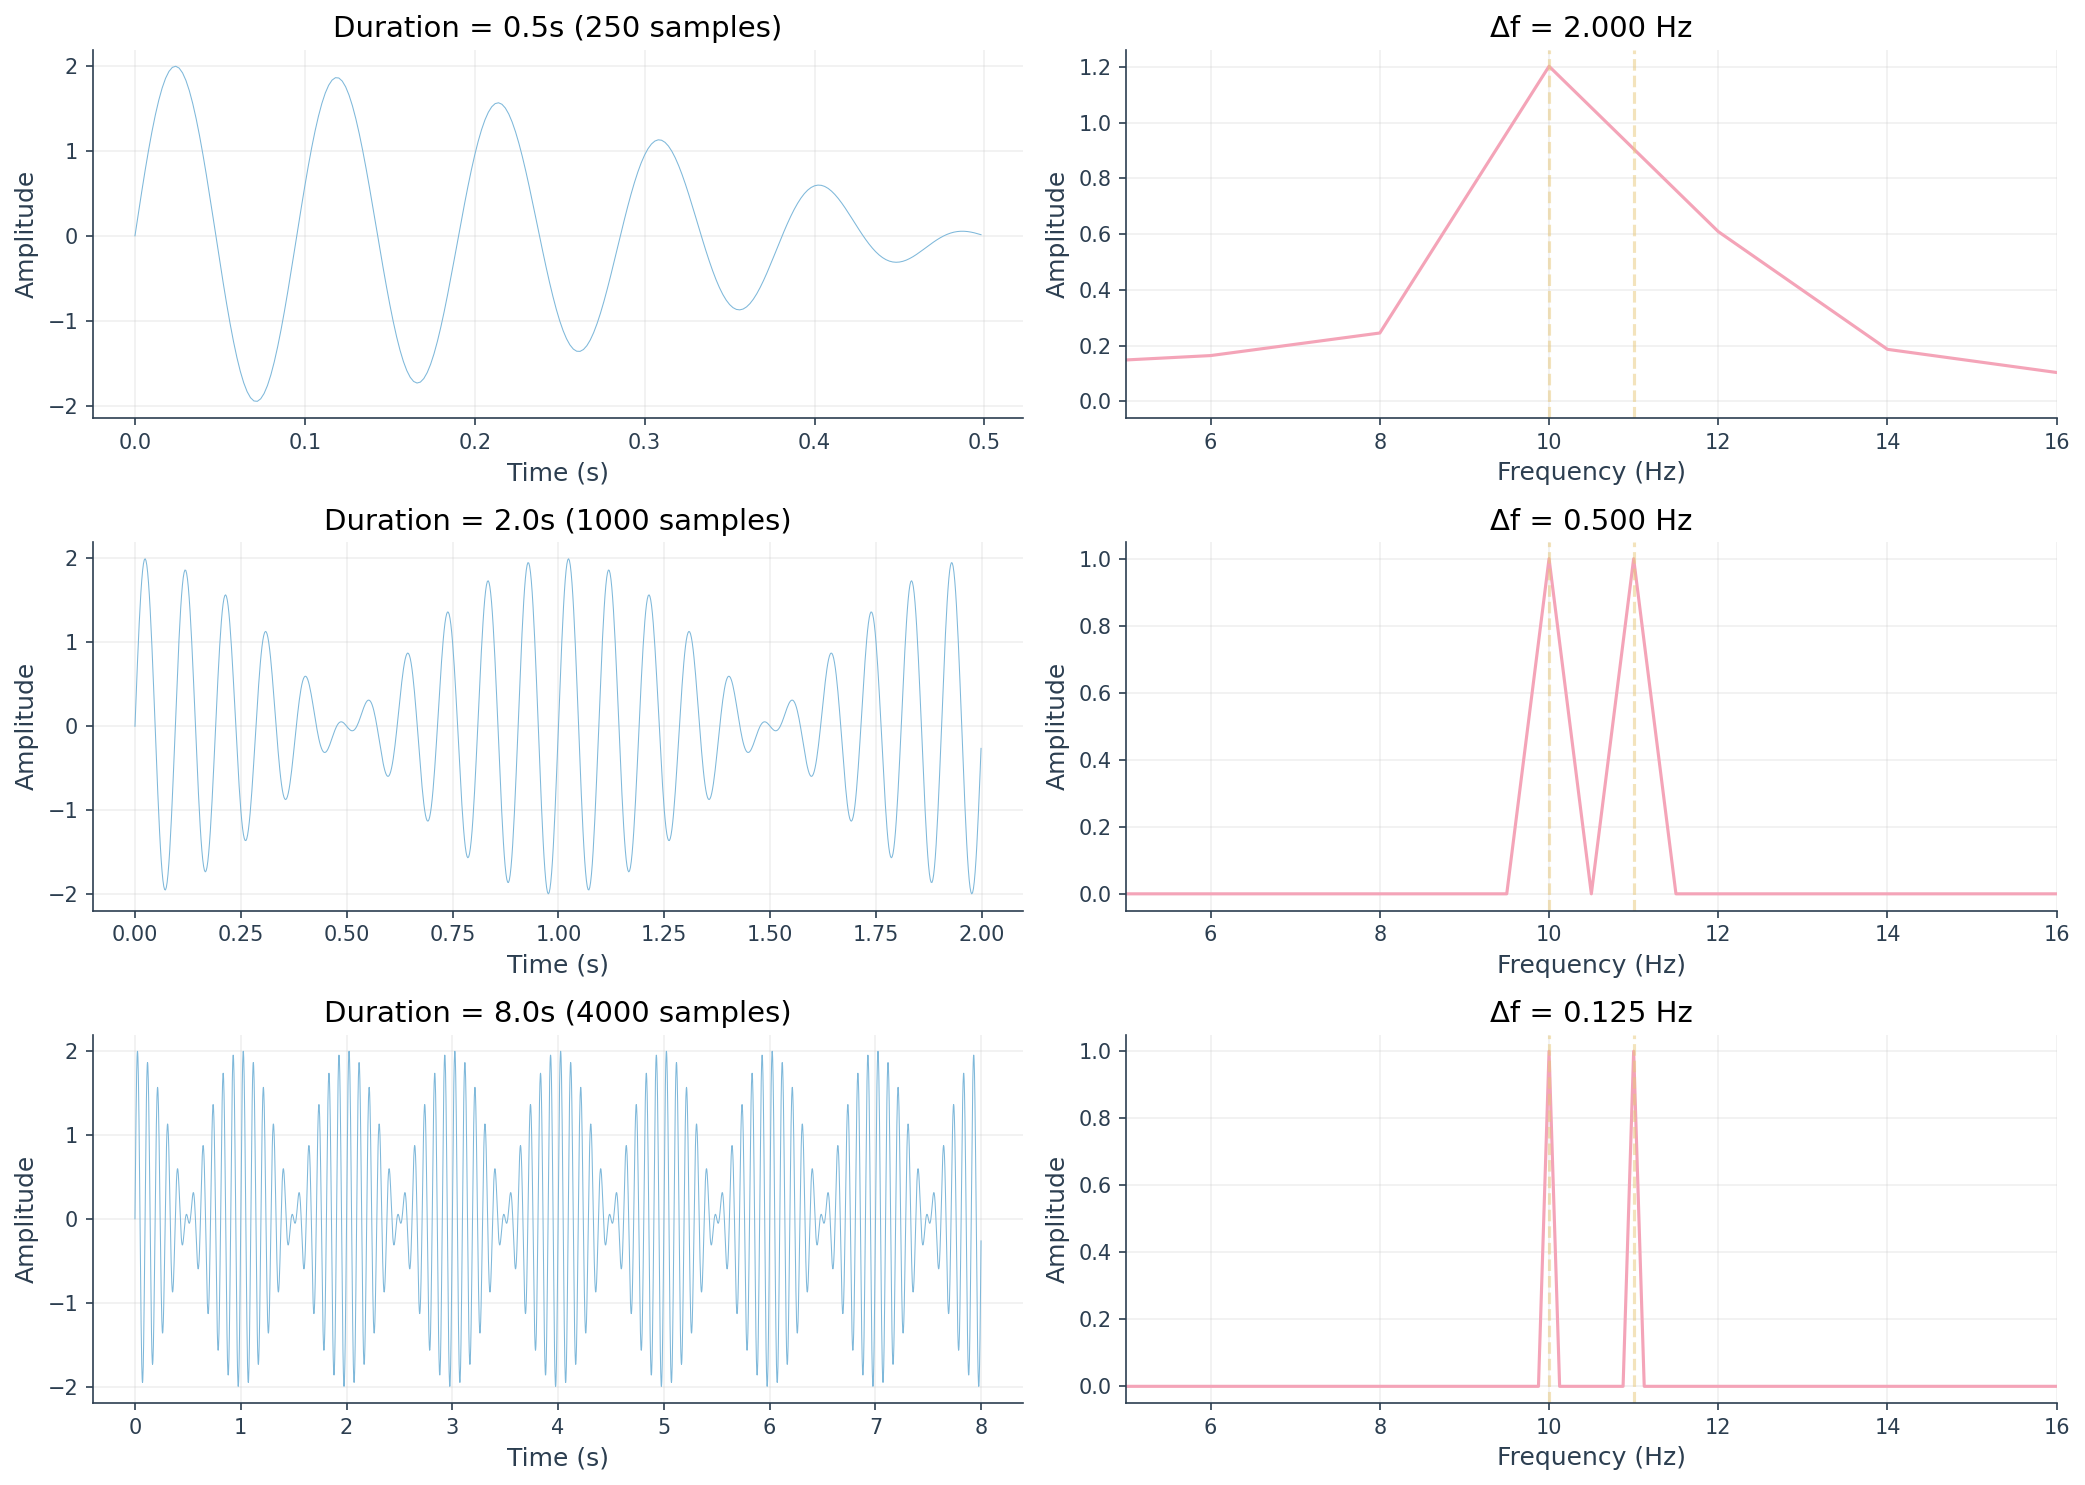

Frequency resolution depends on signal duration, not sampling rate!
To resolve two frequencies Δf apart, you need at least 1.0s of data for Δf = 1 Hz


In [12]:
# Visualization 8: Effect of signal duration on frequency resolution

fs = 500  # Sampling frequency

# Three different signal durations
durations = [0.5, 2.0, 8.0]  # seconds

# Create a signal with two close frequencies
freq_1 = 10  # Hz
freq_2 = 11  # Hz (only 1 Hz apart!)

fig, axes = plt.subplots(len(durations), 2, figsize=(14, 10))

for i, duration in enumerate(durations):
    t = generate_time_vector(duration=duration, fs=fs)
    
    # Generate composite signal
    signal = (generate_sine_wave(t, frequency=freq_1, amplitude=1.0) + 
              generate_sine_wave(t, frequency=freq_2, amplitude=1.0))
    
    # Compute spectrum
    frequencies, amplitude_spectrum = compute_amplitude_spectrum(signal, fs)
    freq_resolution = compute_frequency_resolution(fs, len(t))
    
    # Time domain
    axes[i, 0].plot(t, signal, color=COLORS["signal_1"], linewidth=0.5)
    axes[i, 0].set_xlabel("Time (s)")
    axes[i, 0].set_ylabel("Amplitude")
    axes[i, 0].set_title(f"Duration = {duration}s ({len(t)} samples)")
    axes[i, 0].grid(True, alpha=0.3)
    
    # Frequency domain
    axes[i, 1].plot(frequencies, amplitude_spectrum, color=COLORS["signal_2"], linewidth=1.5)
    axes[i, 1].axvline(freq_1, color=COLORS["signal_4"], linestyle="--", alpha=0.5)
    axes[i, 1].axvline(freq_2, color=COLORS["signal_4"], linestyle="--", alpha=0.5)
    axes[i, 1].set_xlabel("Frequency (Hz)")
    axes[i, 1].set_ylabel("Amplitude")
    axes[i, 1].set_title(f"Δf = {freq_resolution:.3f} Hz")
    axes[i, 1].set_xlim(5, 16)
    axes[i, 1].grid(True, alpha=0.3)
    
    # Add annotation about peak separation
    if freq_resolution > 1:
        axes[i, 1].annotate("Can't resolve peaks!", xy=(10.5, 1.5), fontsize=10, 
                            color=COLORS["signal_4"], fontweight="bold")

plt.tight_layout()
plt.show()

print("Frequency resolution depends on signal duration, not sampling rate!")
print(f"To resolve two frequencies Δf apart, you need at least {1/1:.1f}s of data for Δf = 1 Hz")

---
## 8. Symmetry and One-Sided Spectrum

You may have noticed that the full FFT shows peaks at both positive and negative frequencies. For **real-valued signals** (like EEG), the FFT is **conjugate symmetric**:

$$X[-f] = X^*[f]$$

This means negative frequencies contain the same information as positive frequencies — they're redundant!

**Convention**: We typically show only the **one-sided spectrum** (0 to $f_s/2$), doubling the amplitude to preserve energy.

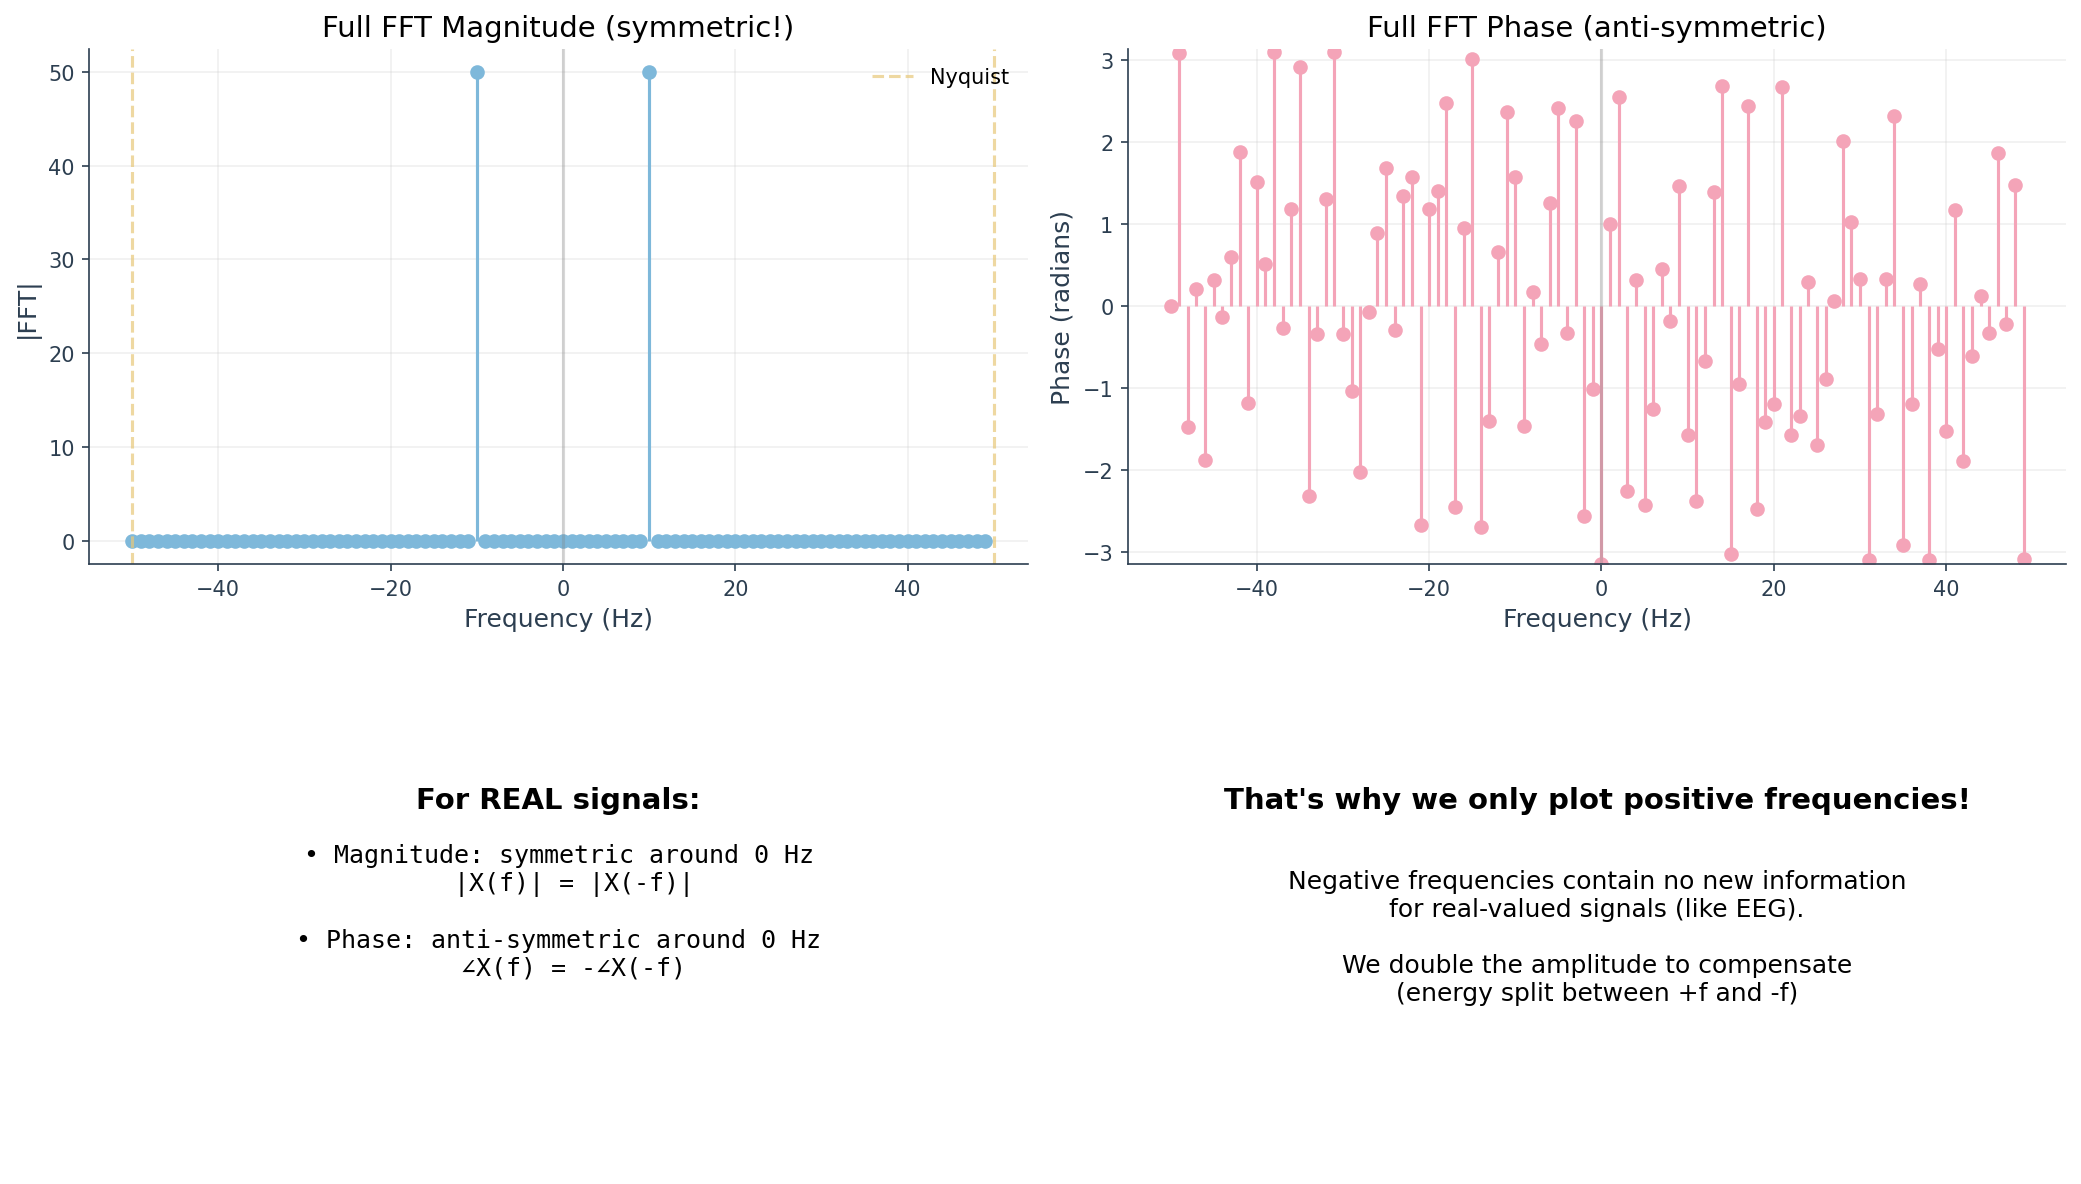

In [13]:
# Visualization 9: FFT symmetry for real signals
# The FFT of a real signal is symmetric around Nyquist frequency

from scipy.fft import fft as scipy_fft, fftfreq as scipy_fftfreq

duration = 1.0
fs = 100  # Low sampling rate to show full spectrum clearly
t = generate_time_vector(duration=duration, fs=fs)
n_samples = len(t)

# Simple signal
signal = generate_sine_wave(t, frequency=10, amplitude=1.0)

# Compute full FFT (not just positive frequencies)
fft_values = scipy_fft(signal)
frequencies_full = scipy_fftfreq(n_samples, 1/fs)

# Sort for plotting
sort_idx = np.argsort(frequencies_full)
frequencies_sorted = frequencies_full[sort_idx]
fft_sorted = fft_values[sort_idx]

# Plot
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Full FFT magnitude
axes[0, 0].stem(frequencies_sorted, np.abs(fft_sorted), linefmt=COLORS["signal_1"], 
                markerfmt="o", basefmt=" ")
axes[0, 0].axvline(0, color="gray", linestyle="-", alpha=0.3)
axes[0, 0].axvline(fs/2, color=COLORS["signal_4"], linestyle="--", alpha=0.7, label="Nyquist")
axes[0, 0].axvline(-fs/2, color=COLORS["signal_4"], linestyle="--", alpha=0.7)
axes[0, 0].set_xlabel("Frequency (Hz)")
axes[0, 0].set_ylabel("|FFT|")
axes[0, 0].set_title("Full FFT Magnitude (symmetric!)")
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Full FFT phase
axes[0, 1].stem(frequencies_sorted, np.angle(fft_sorted), linefmt=COLORS["signal_2"], 
                markerfmt="o", basefmt=" ")
axes[0, 1].axvline(0, color="gray", linestyle="-", alpha=0.3)
axes[0, 1].set_xlabel("Frequency (Hz)")
axes[0, 1].set_ylabel("Phase (radians)")
axes[0, 1].set_title("Full FFT Phase (anti-symmetric)")
axes[0, 1].set_ylim(-np.pi, np.pi)
axes[0, 1].grid(True, alpha=0.3)

# Explanation
axes[1, 0].text(0.5, 0.7, "For REAL signals:", fontsize=14, fontweight="bold",
                ha="center", transform=axes[1, 0].transAxes)
axes[1, 0].text(0.5, 0.5, 
                "• Magnitude: symmetric around 0 Hz\n"
                "  |X(f)| = |X(-f)|\n\n"
                "• Phase: anti-symmetric around 0 Hz\n"
                "  ∠X(f) = -∠X(-f)",
                fontsize=12, ha="center", va="center", transform=axes[1, 0].transAxes,
                family="monospace")
axes[1, 0].axis("off")

# Why we only show positive frequencies
axes[1, 1].text(0.5, 0.7, "That's why we only plot positive frequencies!", 
                fontsize=14, fontweight="bold", ha="center", transform=axes[1, 1].transAxes)
axes[1, 1].text(0.5, 0.45,
                "Negative frequencies contain no new information\n"
                "for real-valued signals (like EEG).\n\n"
                "We double the amplitude to compensate\n"
                "(energy split between +f and -f)",
                fontsize=12, ha="center", va="center", transform=axes[1, 1].transAxes)
axes[1, 1].axis("off")

plt.tight_layout()
plt.show()

---
## 9. Windowing (Brief Introduction)

The FFT assumes the signal is **periodic** — that it repeats forever. But real signals have finite length, and if they don't complete exact cycles within the window, we get **spectral leakage**: energy "leaks" from the true frequency into neighboring bins.

**Windowing** reduces leakage by tapering the signal at the edges. Common windows include:
- **Hann** (Hanning): Good general-purpose choice
- **Hamming**: Similar to Hann, slightly different shape
- **Blackman**: More leakage reduction, but wider main lobe

We'll explore windowing in more depth in A03 (Power Spectrum).

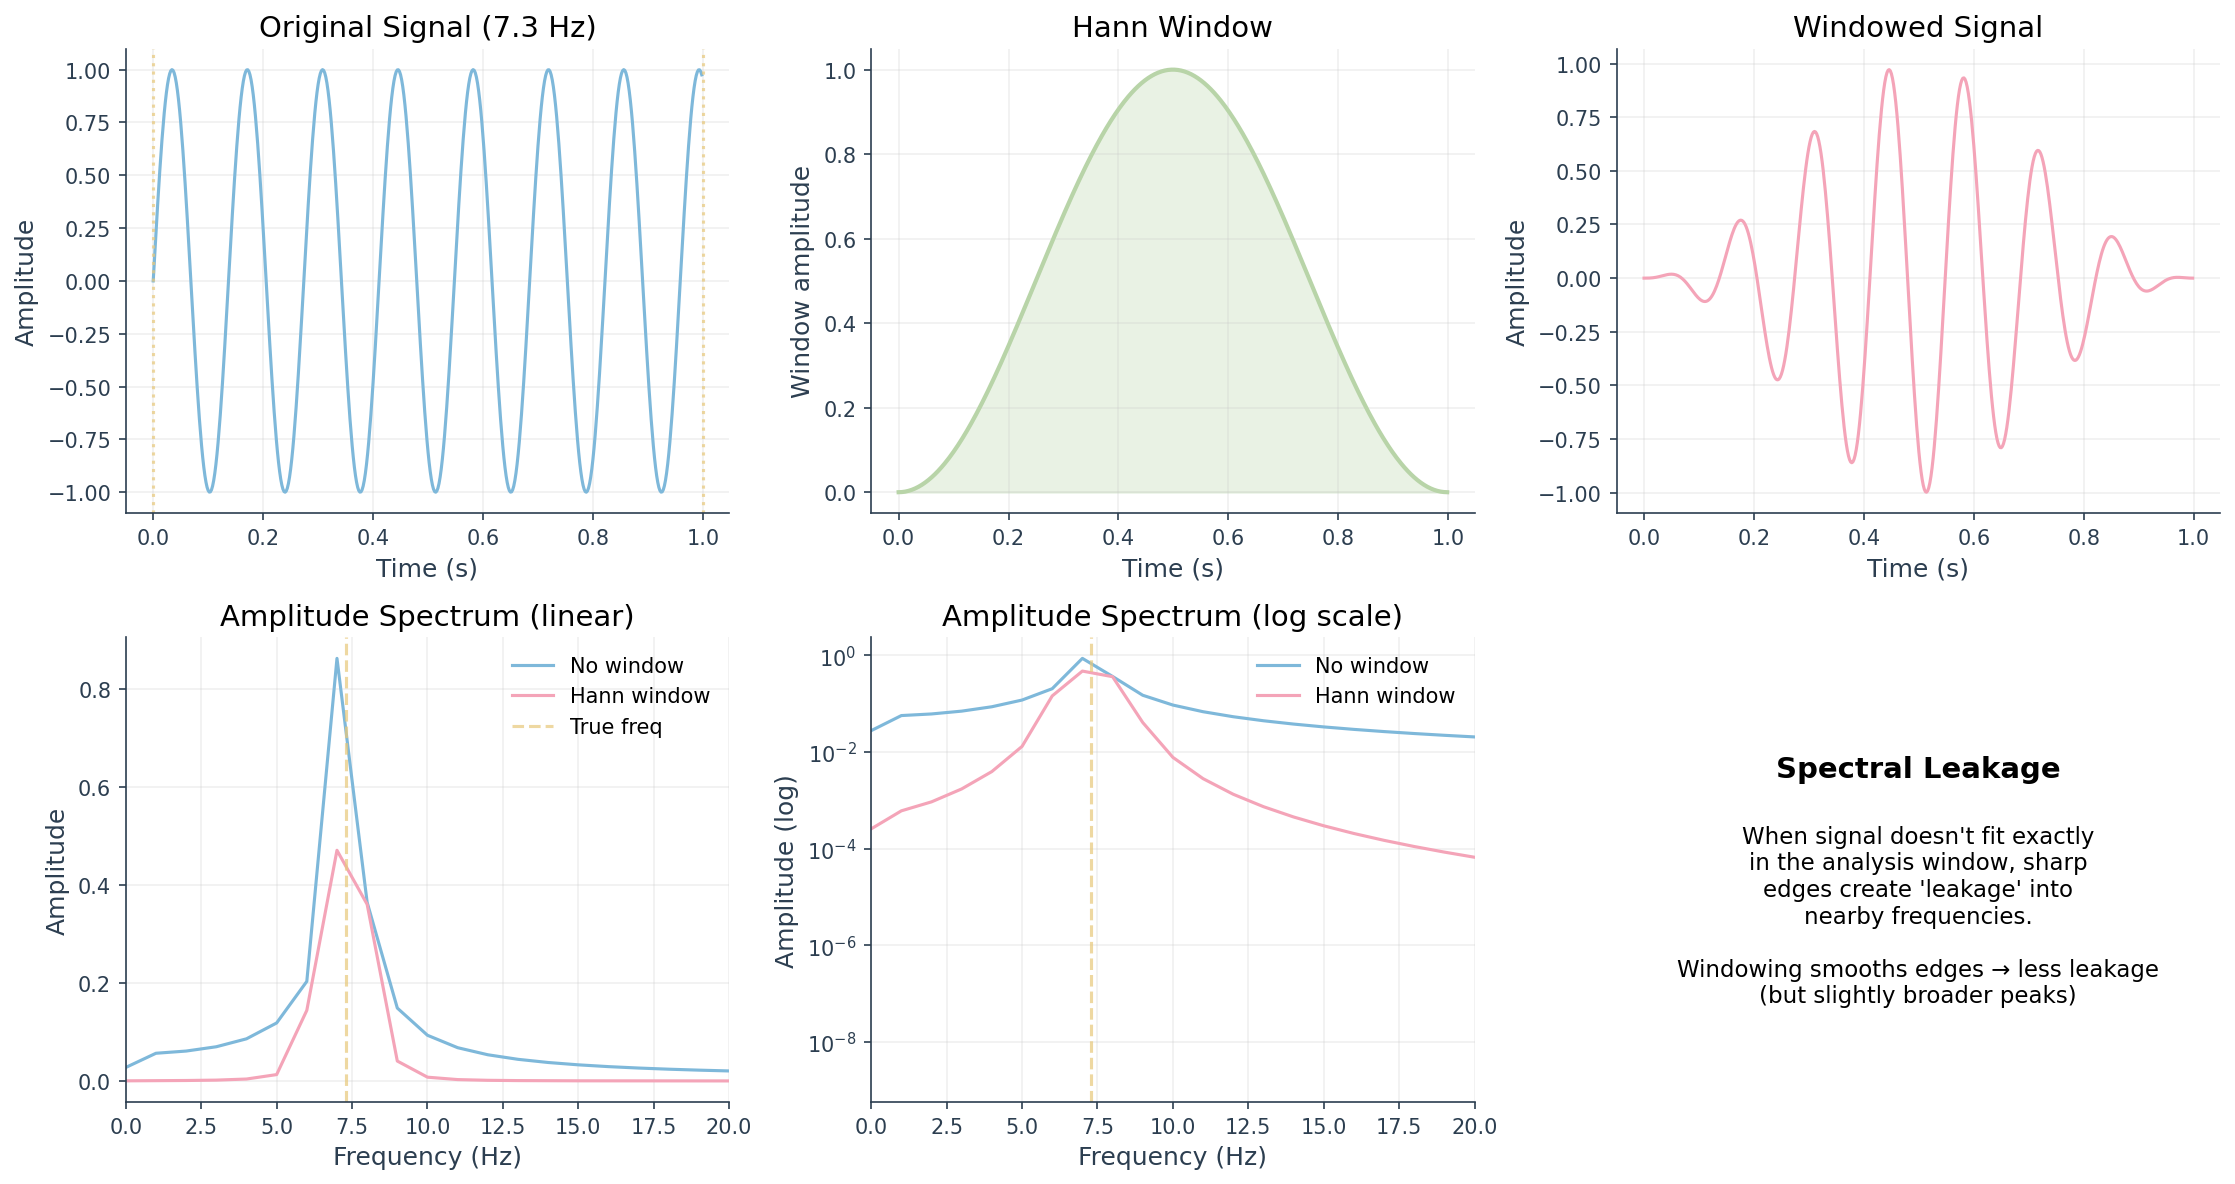

In [14]:
# Visualization 10: Windowing - why and how

duration = 1.0
fs = 500
t = generate_time_vector(duration=duration, fs=fs)

# Create a signal that doesn't have an integer number of cycles
# 7.3 Hz doesn't fit exactly in 1 second
freq = 7.3
signal = generate_sine_wave(t, frequency=freq, amplitude=1.0)

# Apply Hann window
window = np.hanning(len(signal))
signal_windowed = signal * window

# Compute spectra
frequencies, amp_no_window = compute_amplitude_spectrum(signal, fs)
_, amp_windowed = compute_amplitude_spectrum(signal_windowed, fs)

# Plot
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Time domain - original
axes[0, 0].plot(t, signal, color=COLORS["signal_1"], linewidth=1.5)
axes[0, 0].set_xlabel("Time (s)")
axes[0, 0].set_ylabel("Amplitude")
axes[0, 0].set_title("Original Signal (7.3 Hz)")
axes[0, 0].grid(True, alpha=0.3)

# Highlight the discontinuity at edges
axes[0, 0].axvline(0, color=COLORS["signal_4"], linestyle=":", alpha=0.7)
axes[0, 0].axvline(duration, color=COLORS["signal_4"], linestyle=":", alpha=0.7)

# Window function
axes[0, 1].plot(t, window, color=COLORS["signal_3"], linewidth=2)
axes[0, 1].fill_between(t, window, alpha=0.3, color=COLORS["signal_3"])
axes[0, 1].set_xlabel("Time (s)")
axes[0, 1].set_ylabel("Window amplitude")
axes[0, 1].set_title("Hann Window")
axes[0, 1].grid(True, alpha=0.3)

# Windowed signal
axes[0, 2].plot(t, signal_windowed, color=COLORS["signal_2"], linewidth=1.5)
axes[0, 2].set_xlabel("Time (s)")
axes[0, 2].set_ylabel("Amplitude")
axes[0, 2].set_title("Windowed Signal")
axes[0, 2].grid(True, alpha=0.3)

# Spectrum comparison - linear scale
axes[1, 0].plot(frequencies, amp_no_window, color=COLORS["signal_1"], linewidth=1.5, label="No window")
axes[1, 0].plot(frequencies, amp_windowed, color=COLORS["signal_2"], linewidth=1.5, label="Hann window")
axes[1, 0].axvline(freq, color=COLORS["signal_4"], linestyle="--", alpha=0.7, label="True freq")
axes[1, 0].set_xlabel("Frequency (Hz)")
axes[1, 0].set_ylabel("Amplitude")
axes[1, 0].set_title("Amplitude Spectrum (linear)")
axes[1, 0].set_xlim(0, 20)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Spectrum comparison - log scale (shows leakage better)
axes[1, 1].semilogy(frequencies, amp_no_window + 1e-10, color=COLORS["signal_1"], linewidth=1.5, label="No window")
axes[1, 1].semilogy(frequencies, amp_windowed + 1e-10, color=COLORS["signal_2"], linewidth=1.5, label="Hann window")
axes[1, 1].axvline(freq, color=COLORS["signal_4"], linestyle="--", alpha=0.7)
axes[1, 1].set_xlabel("Frequency (Hz)")
axes[1, 1].set_ylabel("Amplitude (log)")
axes[1, 1].set_title("Amplitude Spectrum (log scale)")
axes[1, 1].set_xlim(0, 20)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Explanation
axes[1, 2].text(0.5, 0.7, "Spectral Leakage", fontsize=14, fontweight="bold",
                ha="center", transform=axes[1, 2].transAxes)
axes[1, 2].text(0.5, 0.4,
                "When signal doesn't fit exactly\n"
                "in the analysis window, sharp\n"
                "edges create 'leakage' into\n"
                "nearby frequencies.\n\n"
                "Windowing smooths edges → less leakage\n"
                "(but slightly broader peaks)",
                fontsize=11, ha="center", va="center", transform=axes[1, 2].transAxes)
axes[1, 2].axis("off")

plt.tight_layout()
plt.show()

---
## 10. Practical Example — Composite EEG-like Signal

Let's apply everything we've learned to analyze a realistic EEG-like signal with multiple brain rhythms and noise.

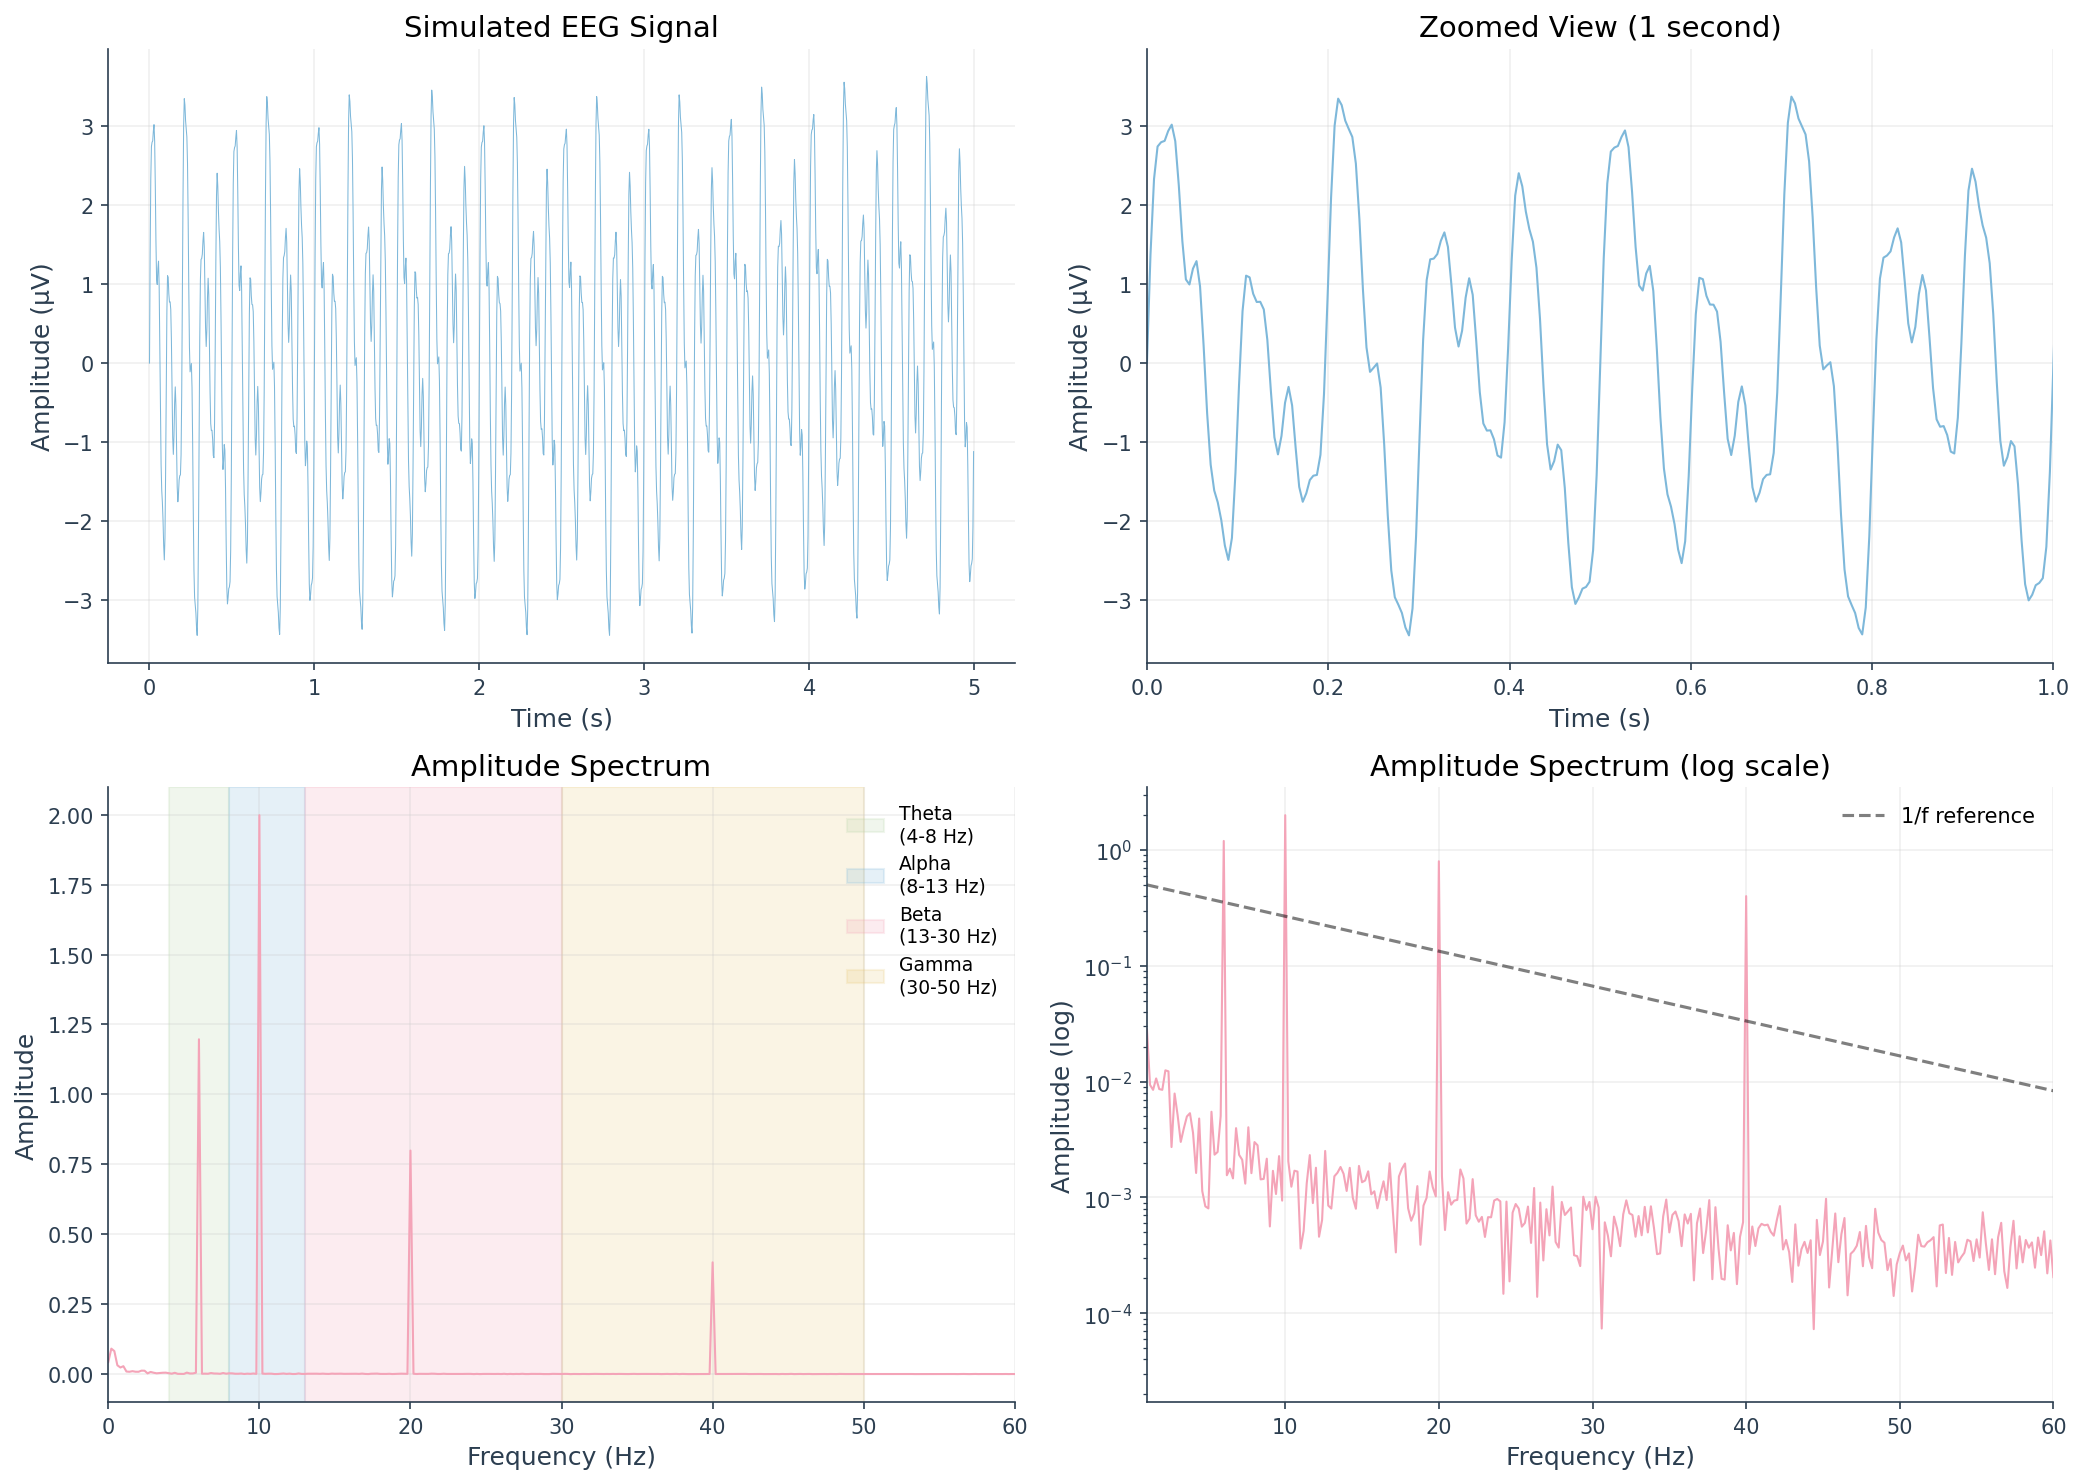

EEG-like signal contains:
  - Theta (6 Hz): associated with memory, drowsiness
  - Alpha (10 Hz): associated with relaxed wakefulness
  - Beta (20 Hz): associated with active thinking
  - Gamma (40 Hz): associated with cognitive processing
  - 1/f noise: characteristic background activity


In [15]:
# Visualization 11: Applying FFT to EEG-like signal
# Analyze frequency content of realistic neural oscillations

duration = 5.0  # 5 seconds of "EEG"
fs = 256  # Common EEG sampling rate
t = generate_time_vector(duration=duration, fs=fs)

# Create a realistic EEG-like signal
np.random.seed(42)  # For reproducibility

# Neural oscillations at different bands
alpha = generate_sine_wave(t, frequency=10, amplitude=2.0)     # Alpha rhythm (10 Hz)
beta = generate_sine_wave(t, frequency=20, amplitude=0.8)      # Beta rhythm (20 Hz)  
theta = generate_sine_wave(t, frequency=6, amplitude=1.2)      # Theta rhythm (6 Hz)
gamma = generate_sine_wave(t, frequency=40, amplitude=0.4)     # Gamma rhythm (40 Hz)

# Add 1/f noise (characteristic of EEG)
noise = np.random.randn(len(t)) * 0.5
# Simple 1/f filtering via cumulative sum
noise_1f = np.cumsum(noise) * 0.01

# Combine all components
eeg_signal = alpha + beta + theta + gamma + noise_1f

# Compute spectrum
frequencies, amplitude_spectrum = compute_amplitude_spectrum(eeg_signal, fs)

# Plot
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Time domain - full signal
axes[0, 0].plot(t, eeg_signal, color=COLORS["signal_1"], linewidth=0.5)
axes[0, 0].set_xlabel("Time (s)")
axes[0, 0].set_ylabel("Amplitude (μV)")
axes[0, 0].set_title("Simulated EEG Signal")
axes[0, 0].grid(True, alpha=0.3)

# Time domain - zoomed
axes[0, 1].plot(t, eeg_signal, color=COLORS["signal_1"], linewidth=1)
axes[0, 1].set_xlabel("Time (s)")
axes[0, 1].set_ylabel("Amplitude (μV)")
axes[0, 1].set_title("Zoomed View (1 second)")
axes[0, 1].set_xlim(0, 1)
axes[0, 1].grid(True, alpha=0.3)

# Frequency domain - linear
axes[1, 0].plot(frequencies, amplitude_spectrum, color=COLORS["signal_2"], linewidth=1)
axes[1, 0].set_xlabel("Frequency (Hz)")
axes[1, 0].set_ylabel("Amplitude")
axes[1, 0].set_title("Amplitude Spectrum")
axes[1, 0].set_xlim(0, 60)
axes[1, 0].grid(True, alpha=0.3)

# Mark frequency bands
bands = {
    "Theta\n(4-8 Hz)": (4, 8, COLORS["signal_3"]),
    "Alpha\n(8-13 Hz)": (8, 13, COLORS["signal_1"]),
    "Beta\n(13-30 Hz)": (13, 30, COLORS["signal_2"]),
    "Gamma\n(30-50 Hz)": (30, 50, COLORS["signal_4"]),
}

for band_name, (f_low, f_high, color) in bands.items():
    axes[1, 0].axvspan(f_low, f_high, alpha=0.2, color=color, label=band_name)

axes[1, 0].legend(loc="upper right", fontsize=9)

# Frequency domain - log scale (shows 1/f better)
axes[1, 1].semilogy(frequencies[1:], amplitude_spectrum[1:], color=COLORS["signal_2"], linewidth=1)
axes[1, 1].set_xlabel("Frequency (Hz)")
axes[1, 1].set_ylabel("Amplitude (log)")
axes[1, 1].set_title("Amplitude Spectrum (log scale)")
axes[1, 1].set_xlim(1, 60)
axes[1, 1].grid(True, alpha=0.3)

# Add 1/f reference line
f_ref = np.array([1, 60])
axes[1, 1].plot(f_ref, 0.5/f_ref, 'k--', alpha=0.5, label="1/f reference")
axes[1, 1].legend()

plt.tight_layout()
plt.show()

print("EEG-like signal contains:")
print("  - Theta (6 Hz): associated with memory, drowsiness")
print("  - Alpha (10 Hz): associated with relaxed wakefulness")
print("  - Beta (20 Hz): associated with active thinking")
print("  - Gamma (40 Hz): associated with cognitive processing")
print("  - 1/f noise: characteristic background activity")

---
## 11. Hands-On Exercises

### Exercise 1: Mystery Signal Analysis

A signal is provided below. Use the FFT to identify its component frequencies.

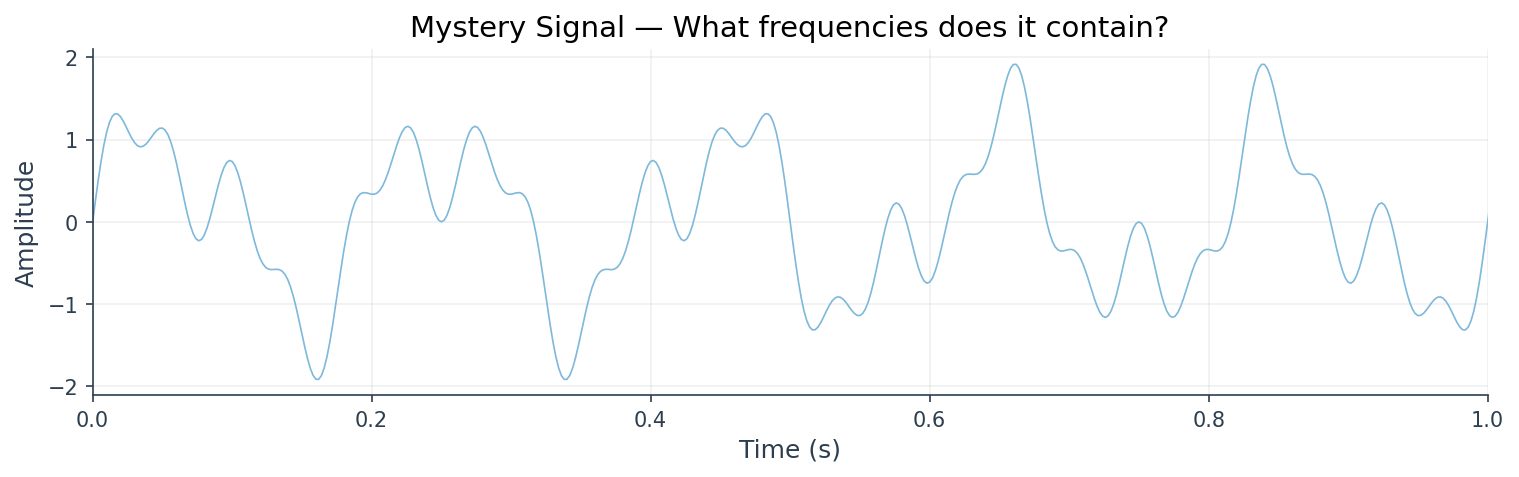

In [16]:
# Exercise 1: Mystery signal - what frequencies are present?
np.random.seed(123)
fs_ex1 = 500
duration_ex1 = 3.0
t_ex1 = generate_time_vector(duration=duration_ex1, fs=fs_ex1)

# Mystery signal (don't peek at the code!)
mystery_signal = (
    generate_sine_wave(5, t_ex1, 1.0) +
    generate_sine_wave(11, t_ex1, 0.6) +
    generate_sine_wave(23, t_ex1, 0.4)
)

# Plot the mystery signal
plt.figure(figsize=(12, 3))
plt.plot(t_ex1, mystery_signal, color=COLORS["signal_1"], linewidth=0.8)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Mystery Signal — What frequencies does it contain?")
plt.xlim(0, 1)
plt.grid(True, alpha=0.3)
plt.show()

# TODO: Use compute_amplitude_spectrum to find the component frequencies
# freqs, amps = compute_amplitude_spectrum(mystery_signal, fs_ex1)
# Then plot and identify the peaks!

<details>
<summary>👉 Click here to see the answer</summary>

**Answer**:

```python
freqs, amps = compute_amplitude_spectrum(mystery_signal, fs_ex1)

plt.figure(figsize=(10, 4))
plt.plot(freqs, amps, color=COLORS["signal_1"], linewidth=1.5)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title("Mystery Signal — Amplitude Spectrum")
plt.xlim(0, 40)
plt.grid(True, alpha=0.3)
plt.show()

# Find peaks
peak_threshold = 0.2
peak_freqs = freqs[amps > peak_threshold]
print(f"Component frequencies: {peak_freqs}")
```

**Explanation**:

The mystery signal contains three frequencies: **5 Hz**, **11 Hz**, and **23 Hz**.

The amplitude spectrum clearly shows three peaks at these frequencies, with decreasing amplitudes (1.0, 0.6, 0.4). This demonstrates how the FFT can decompose a complex-looking time-domain signal into its constituent oscillations.

</details>

### Exercise 2: Amplitude vs Phase

Two signals are provided that look different in the time domain. Analyze them to determine how they differ.

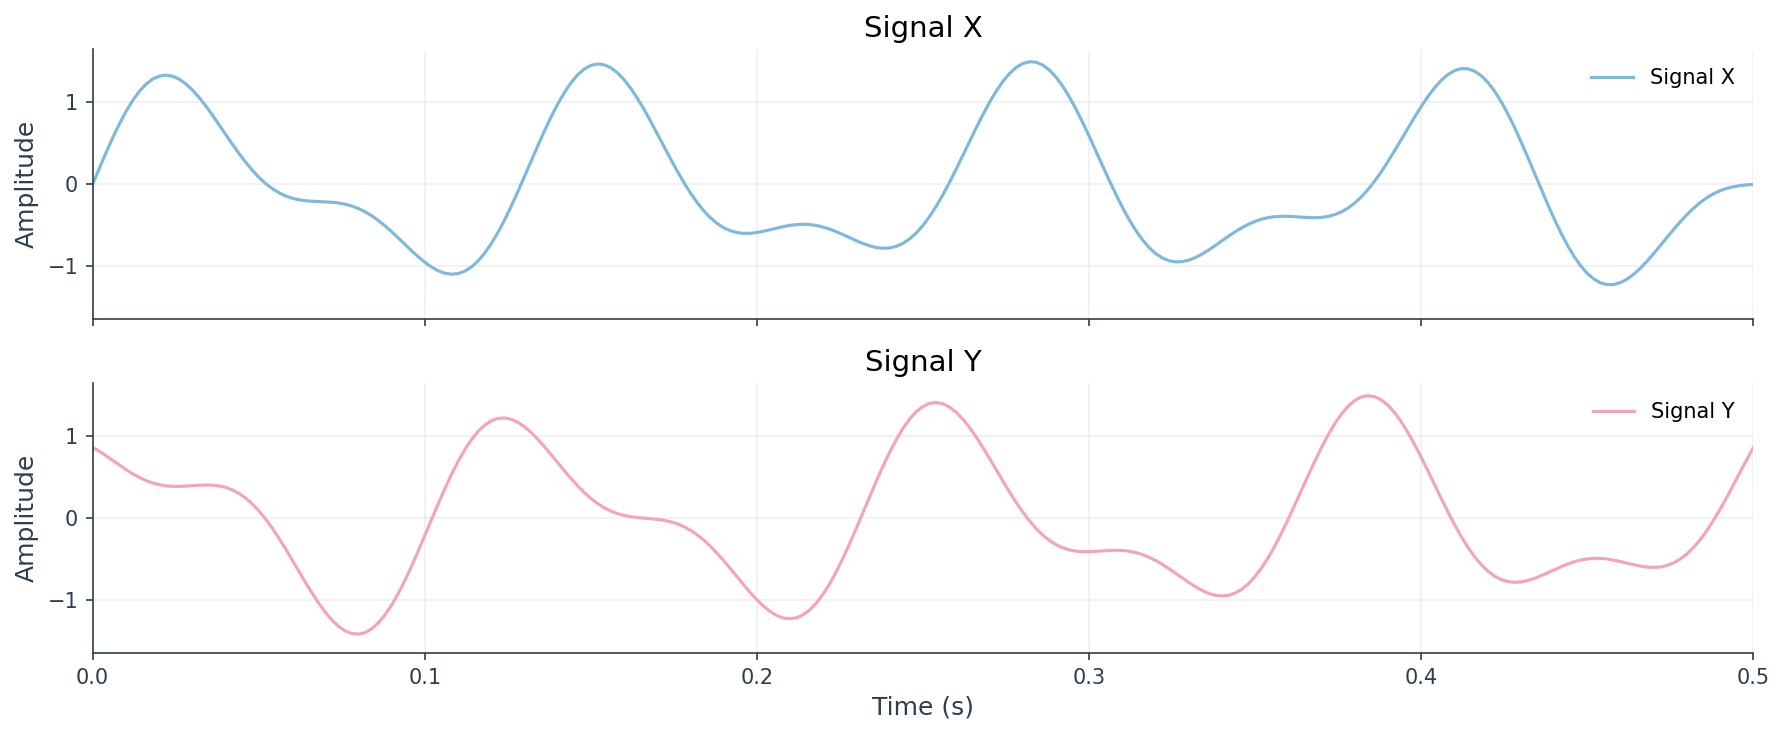

In [17]:
# Exercise 2: Two signals that look different - how do they differ?
fs_ex2 = 500
duration_ex2 = 2.0
t_ex2 = generate_time_vector(duration=duration_ex2, fs=fs_ex2)

# Signal X
signal_X = (
    generate_sine_wave(8, t_ex2, 1.0, phase=0) +
    generate_sine_wave(15, t_ex2, 0.5, phase=0)
)

# Signal Y  
signal_Y = (
    generate_sine_wave(8, t_ex2, 1.0, phase=np.pi/3) +
    generate_sine_wave(15, t_ex2, 0.5, phase=np.pi)
)

# Plot both signals
fig, axes = plt.subplots(2, 1, figsize=(12, 5), sharex=True)
axes[0].plot(t_ex2, signal_X, color=COLORS["signal_1"], linewidth=1.5, label="Signal X")
axes[0].set_ylabel("Amplitude")
axes[0].set_title("Signal X")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(t_ex2, signal_Y, color=COLORS["signal_2"], linewidth=1.5, label="Signal Y")
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("Amplitude")
axes[1].set_title("Signal Y")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

for ax in axes:
    ax.set_xlim(0, 0.5)

plt.tight_layout()
plt.show()

# TODO: Compare amplitude and phase spectra of both signals
# How do they differ? Same frequencies? Same amplitudes? Different phases?

<details>
<summary>👉 Click here to see the answer</summary>

**Answer**:

```python
# Compute amplitude spectra
freqs_X, amp_X = compute_amplitude_spectrum(signal_X, fs_ex2)
freqs_Y, amp_Y = compute_amplitude_spectrum(signal_Y, fs_ex2)

# Compute phase spectra
_, phase_X = compute_phase_spectrum(signal_X, fs_ex2)
_, phase_Y = compute_phase_spectrum(signal_Y, fs_ex2)

fig, axes = plt.subplots(2, 2, figsize=(12, 6))

# Amplitude spectra
axes[0, 0].plot(freqs_X, amp_X, color=COLORS["signal_1"], linewidth=1.5)
axes[0, 0].set_title("Amplitude Spectrum X")
axes[0, 0].set_xlim(0, 25)
axes[0, 1].plot(freqs_Y, amp_Y, color=COLORS["signal_2"], linewidth=1.5)
axes[0, 1].set_title("Amplitude Spectrum Y")
axes[0, 1].set_xlim(0, 25)

# Phase at key frequencies
idx_8 = np.argmin(np.abs(freqs_X - 8))
idx_15 = np.argmin(np.abs(freqs_X - 15))
print(f"At 8 Hz: Phase X = {phase_X[idx_8]:.2f} rad, Phase Y = {phase_Y[idx_8]:.2f} rad")
print(f"At 15 Hz: Phase X = {phase_X[idx_15]:.2f} rad, Phase Y = {phase_Y[idx_15]:.2f} rad")
```

**Explanation**:

Both signals have **identical amplitude spectra** — they contain the same frequencies (8 Hz and 15 Hz) with the same amplitudes (1.0 and 0.5).

The difference is in their **phases**:
- Signal X: both components start at phase 0
- Signal Y: 8 Hz component has phase π/3, 15 Hz component has phase π

This confirms that signals can look completely different in time domain while having identical frequency content — the phase information is what distinguishes them!

</details>

### Exercise 3: Frequency Resolution

Two close frequencies (10 Hz and 11 Hz) are mixed. Determine the minimum signal duration needed to resolve them as separate peaks.

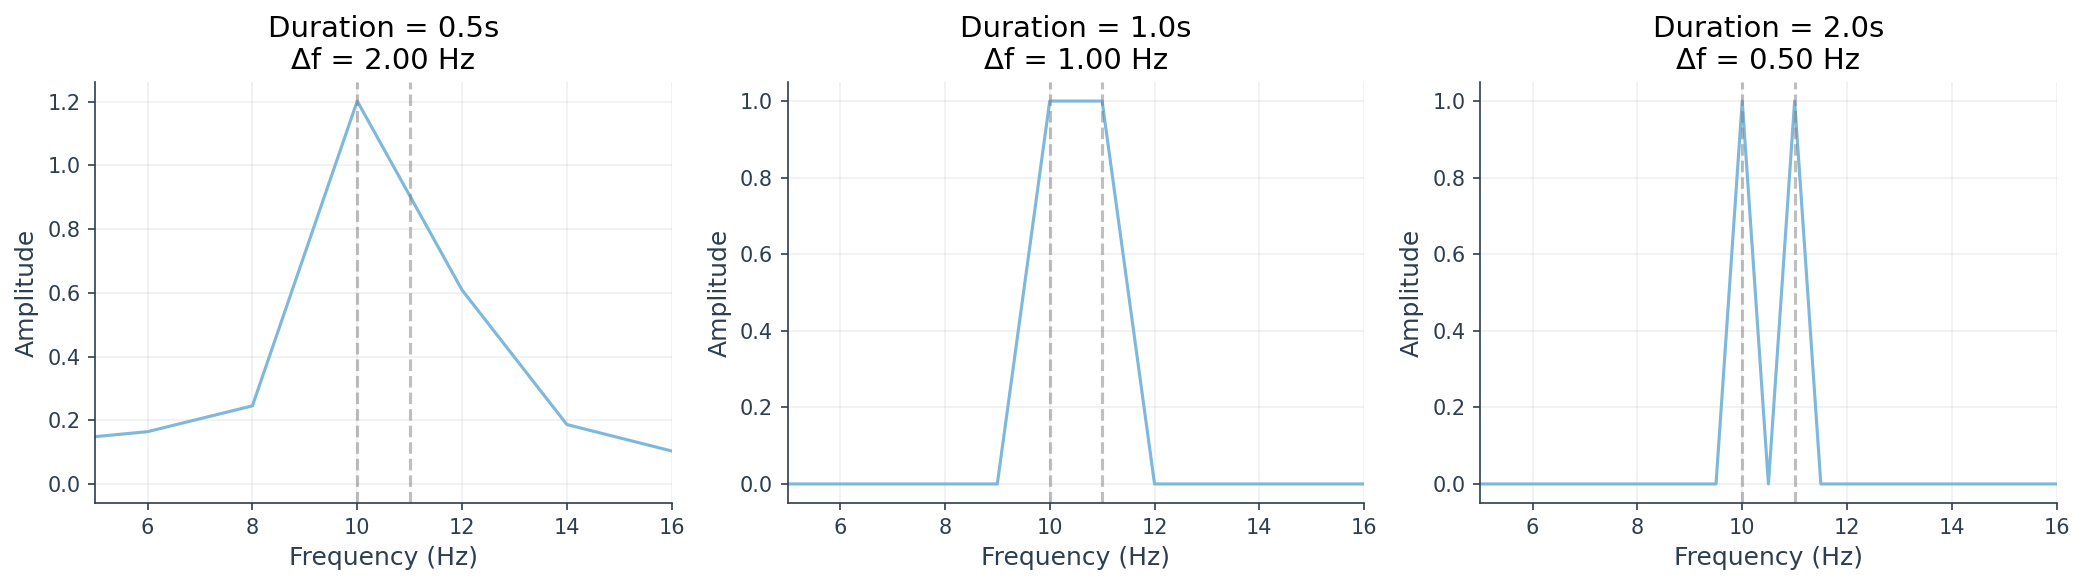

In [18]:
# Exercise 3: Frequency resolution challenge
# Two close frequencies: 10 Hz and 11 Hz
# What duration is needed to see them as separate peaks?

fs_ex3 = 500
freq_A, freq_B = 10, 11  # Hz - only 1 Hz apart

# Try different durations
test_durations = [0.5, 1.0, 2.0]

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

for ax, dur in zip(axes, test_durations):
    t_test = generate_time_vector(duration=dur, fs=fs_ex3)
    signal_test = (
        generate_sine_wave(freq_A, t_test, 1.0) +
        generate_sine_wave(freq_B, t_test, 1.0)
    )
    freqs_test, amps_test = compute_amplitude_spectrum(signal_test, fs_ex3)
    delta_f = compute_frequency_resolution(fs_ex3, len(t_test))
    
    ax.plot(freqs_test, amps_test, color=COLORS["signal_1"], linewidth=1.5)
    ax.set_xlabel("Frequency (Hz)")
    ax.set_ylabel("Amplitude")
    ax.set_title(f"Duration = {dur}s\nΔf = {delta_f:.2f} Hz")
    ax.set_xlim(5, 16)
    ax.axvline(freq_A, color="gray", linestyle="--", alpha=0.5)
    ax.axvline(freq_B, color="gray", linestyle="--", alpha=0.5)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# TODO: What is the minimum duration to resolve 10 Hz and 11 Hz as separate peaks?
# Hint: What frequency resolution is needed? Δf = 1/T

<details>
<summary>👉 Click here to see the answer</summary>

**Answer**:

To resolve two frequencies separated by 1 Hz, we need:
$$\Delta f \leq 1 \text{ Hz} \Rightarrow T \geq 1 \text{ second}$$

**Explanation**:

- At **0.5 seconds**: Δf = 2 Hz — the peaks merge into one broad peak (cannot resolve)
- At **1.0 second**: Δf = 1 Hz — peaks just barely separated (borderline resolution)
- At **2.0 seconds**: Δf = 0.5 Hz — peaks clearly separated (good resolution)

The rule of thumb: **to resolve frequencies Δf Hz apart, you need at least 1/Δf seconds of data**.

This has practical implications for EEG:
- To distinguish alpha sub-bands (8-10 Hz vs 10-12 Hz), you need at least 0.5 seconds
- To separate 10 Hz from 10.5 Hz, you need at least 2 seconds
- Short epochs sacrifice frequency resolution for temporal precision

</details>

---
## Summary

### Key Takeaways

1. **The Fourier transform decomposes signals into constituent oscillations** — any signal can be represented as a sum of sine waves

2. **FFT is the efficient algorithm** to compute the Discrete Fourier Transform in $O(N \log N)$ time

3. **Amplitude spectrum** shows the strength of each frequency component: $|X[k]| = \sqrt{a^2 + b^2}$

4. **Phase spectrum** shows the timing offset of each component: $\phi = \text{atan2}(b, a)$

5. **Frequency resolution depends on signal duration**: $\Delta f = 1/T$ — longer signals give finer resolution

6. **For real signals, the spectrum is symmetric** — we typically show only positive frequencies (one-sided spectrum)

7. **Windowing reduces spectral leakage** from finite-length signals

### Functions Created

| Function | Description |
|----------|-------------|
| `compute_fft(signal, fs)` | Compute full FFT with frequency axis |
| `compute_amplitude_spectrum(signal, fs)` | One-sided normalized amplitude spectrum |
| `compute_phase_spectrum(signal, fs)` | One-sided phase spectrum |
| `compute_frequency_resolution(fs, n_samples)` | Calculate Δf |

These functions are available in `src/spectral.py` for future notebooks.

---
## Discussion Questions

1. **You record 1 second of EEG data. Can you distinguish between 10 Hz and 10.5 Hz oscillations? What about with 3 seconds of data?**

2. **Two EEG channels show identical amplitude spectra but different phase spectra. What might this indicate about the relationship between these brain regions?**

3. **Why do you think most EEG connectivity metrics (coherence, PLV, etc.) operate in the frequency domain rather than the time domain?**

4. **A colleague shows you an amplitude spectrum with a very sharp, narrow peak. What does this tell you about the underlying signal?**

5. **In hyperscanning, we analyze two brains simultaneously. How might phase relationships between two participants' EEG signals at the same frequency be meaningful?**

---
## Next Steps

In the next notebook (**A03: Power Spectrum and Frequency Bands**), we will:
- Learn about power spectral density (PSD)
- Explore Welch's method for robust spectral estimation
- Define and extract EEG frequency bands (delta, theta, alpha, beta, gamma)
- Understand the relationship between amplitude and power